<a href="https://colab.research.google.com/github/alexkcode/pcb-defect-detection-yolo/blob/main/PCB-Defect-Detection-Using-Autoencoder-and-YOLOv11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Architecture Code

https://colab.research.google.com/drive/1qNSRqWz-ZaiKzDddGXJUyxaZNryV207l?usp=sharing

## 1: Dependency Installation and Directory Setup

In [ ]:
# Install required packages
!pip install ultralytics roboflow tensorflow opencv-python matplotlib seaborn

# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import json
import zipfile
from pathlib import Path
import time
from google.colab import drive
import torch
import gc


### 1.0: GPU Config

In [ ]:
import tensorflow as tf
import os

def configure_gpu_memory():
    """Configure GPU memory BEFORE any TensorFlow operations"""
    try:
        # Get GPU devices
        gpus = tf.config.experimental.list_physical_devices('GPU')

        if gpus:
            # Configure memory growth for each GPU
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)

            print(f"✅ Memory growth enabled for {len(gpus)} GPU(s)")

            # Optional: Set memory limit (uncomment if needed)
            # tf.config.experimental.set_memory_limit(gpus[0], 10240)  # 10GB limit

            return True
        else:
            print("❌ No GPU devices found")
            return False

    except RuntimeError as e:
        print(f"❌ GPU configuration failed: {e}")
        print("Solution: Restart runtime and run this cell first")
        return False

# Configure GPU immediately
gpu_configured = configure_gpu_memory()

# Verify configuration
if gpu_configured:
    print("GPU Memory Configuration:")
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for i, gpu in enumerate(gpus):
        memory_growth = tf.config.experimental.get_memory_growth(gpu)
        print(f"   GPU {i}: Memory growth = {memory_growth}")

def clear_gpu_memory_startup():
    """
    Clear GPU memory at notebook startup - NO PyTorch required
    """
    import os
    import gc
    import subprocess

    print("Clearing GPU Memory at Startup")
    print("=" * 40)

    # Method 1: Kill existing GPU processes
    try:
        # Get GPU processes
        result = subprocess.run(['nvidia-smi', '--query-compute-apps=pid', '--format=csv,noheader,nounits'],
                              capture_output=True, text=True)

        if result.returncode == 0 and result.stdout.strip():
            pids = result.stdout.strip().split('\n')
            print(f"Found {len(pids)} GPU processes to kill")

            for pid in pids:
                if pid.strip():
                    try:
                        subprocess.run(['kill', '-9', pid.strip()], check=True)
                        print(f"✅ Killed process {pid.strip()}")
                    except subprocess.CalledProcessError:
                        print(f"⚠️ Could not kill process {pid.strip()}")
        else:
            print("✅ No GPU processes found")

    except Exception as e:
        print(f"⚠️ Process killing failed: {e}")

    # Method 2: GPU Reset (if available)
    try:
        # Note: This may not work in all Colab environments
        result = subprocess.run(['nvidia-smi', '--gpu-reset'], capture_output=True, text=True)
        if result.returncode == 0:
            print("✅ GPU reset successful")
        else:
            print("⚠️ GPU reset not available (normal in Colab)")
    except Exception as e:
        print(f"⚠️ GPU reset failed: {e}")

    # Method 3: Clear system memory
    gc.collect()

    # Method 4: Check current GPU status
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used,memory.total',
                               '--format=csv,nounits,noheader'],
                              capture_output=True, text=True)

        if result.returncode == 0:
            memory_info = result.stdout.strip().split(', ')
            used_mb = int(memory_info[0])
            total_mb = int(memory_info[1])

            print(f"GPU Memory After Cleanup: {used_mb}MB / {total_mb}MB ({used_mb/total_mb*100:.1f}% used)")

            if used_mb > 1000:  # More than 1GB still used
                print("⚠️ WARNING: Significant GPU memory still in use")
                print("Consider restarting runtime if issues persist")
            else:
                print("✅ GPU memory successfully cleared")

        else:
            print("❌ Could not check GPU memory status")

    except Exception as e:
        print(f"❌ Memory check failed: {e}")

# Call this FIRST in your notebook
clear_gpu_memory_startup()


✅ Memory growth enabled for 1 GPU(s)
GPU Memory Configuration:
   GPU 0: Memory growth = True
Clearing GPU Memory at Startup
Found 1 GPU processes to kill
⚠️ Could not kill process 1971806
⚠️ GPU reset not available (normal in Colab)
GPU Memory After Cleanup: 9293MB / 23034MB (40.3% used)
⚠️ WARNING: Significant GPU memory still in use
Consider restarting runtime if issues persist


### 1.1: Directories

In [ ]:
# Directory Configuration
PROJECT_ROOT = '/content/drive/MyDrive/pcb_defect_detection' # Mount Google Drive for persistence
AUTOENCODER_DIR = f'{PROJECT_ROOT}/autoencoder'
YOLO_DIR = f'{PROJECT_ROOT}/yolo'
RESULTS_DIR = f'{PROJECT_ROOT}/results'

# Temporary directory for dataset extraction (local to Colab session)
TEMP_DATASET_EXTRACT_DIR = '/content/temp_datasets'  # Local temp directory

# Create all necessary directories
directories = [
    PROJECT_ROOT, AUTOENCODER_DIR, YOLO_DIR, RESULTS_DIR,
    TEMP_DATASET_EXTRACT_DIR,
    f'{AUTOENCODER_DIR}/models',
    f'{AUTOENCODER_DIR}/checkpoints',
    f'{YOLO_DIR}/baseline',
    f'{YOLO_DIR}/enhanced',
    f'{RESULTS_DIR}/plots',
    f'{RESULTS_DIR}/evaluations'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"Directory ready: {directory}")

print("Environment setup complete!")

Directory ready: /content/drive/MyDrive/pcb_defect_detection
Directory ready: /content/drive/MyDrive/pcb_defect_detection/autoencoder
Directory ready: /content/drive/MyDrive/pcb_defect_detection/yolo
Directory ready: /content/drive/MyDrive/pcb_defect_detection/results
Directory ready: /content/temp_datasets
Directory ready: /content/drive/MyDrive/pcb_defect_detection/autoencoder/models
Directory ready: /content/drive/MyDrive/pcb_defect_detection/autoencoder/checkpoints
Directory ready: /content/drive/MyDrive/pcb_defect_detection/yolo/baseline
Directory ready: /content/drive/MyDrive/pcb_defect_detection/yolo/enhanced
Directory ready: /content/drive/MyDrive/pcb_defect_detection/results/plots
Directory ready: /content/drive/MyDrive/pcb_defect_detection/results/evaluations
Environment setup complete!


### 1.2: Zip Loader

In [ ]:
def load_images_from_zip_for_autoencoder(zip_path, target_size=(400, 400), max_images=None):
    """
    Load and preprocess images from zip file for autoencoder training.
    Resizes images to target_size and normalizes to [0,1] range.

    Args:
        zip_path (str): Path to the dataset zip file
        target_size (tuple): Target image size for autoencoder (width, height)
        max_images (int): Maximum number of images to load (None for all)

    Returns:
        np.ndarray: Preprocessed images array with shape (n_samples, height, width, channels)
    """
    print(f"Loading images from zip for autoencoder training...")
    print(f"   Zip file: {zip_path}")
    print(f"   Target size: {target_size}")

    images = []
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Get all image files from zip
            image_files = [f for f in zip_ref.namelist()
                          if any(f.lower().endswith(ext) for ext in valid_extensions)
                          and not f.startswith('__MACOSX')  # Skip macOS metadata
                          and not os.path.basename(f).startswith('.')]  # Skip hidden files

            print(f"   Found {len(image_files)} image files in zip")

            # Limit number of images if specified
            if max_images and len(image_files) > max_images:
                image_files = image_files[:max_images]
                print(f"   Limited to {max_images} images for processing")

            # Process images
            for i, image_file in enumerate(image_files):
                try:
                    # Read image data
                    with zip_ref.open(image_file) as file:
                        image_data = file.read()

                    # Convert to numpy array
                    nparr = np.frombuffer(image_data, np.uint8)
                    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

                    if image is not None:
                        # Convert BGR to RGB
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                        # Resize to target size
                        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

                        # Normalize to [0, 1] range
                        image = image.astype(np.float32) / 255.0

                        images.append(image)

                        # Progress update
                        if (i + 1) % 100 == 0:
                            print(f"   Processed {i + 1}/{len(image_files)} images...")

                except Exception as e:
                    print(f"   Warning: Could not process {image_file}: {e}")
                    continue

        images_array = np.array(images)
        print(f"Successfully loaded {len(images_array)} images")
        print(f"   Final shape: {images_array.shape}")
        print(f"   Data type: {images_array.dtype}")
        print(f"   Value range: [{images_array.min():.3f}, {images_array.max():.3f}]")

        return images_array

    except Exception as e:
        print(f"❌ Error loading images from zip: {e}")
        return None

In [ ]:
import os
import zipfile
from roboflow import Roboflow
from pathlib import Path

def robust_pcb_dataset_download(dataset_name="pcb_dataset", force_redownload=False):
    """
    Robust PCB dataset download with existence checks and validation

    Args:
        dataset_name: Name for the dataset folder/zip
        force_redownload: If True, redownload even if files exist
    """

    zip_filename = f"{dataset_name}.zip"
    dataset_folder = dataset_name

    # Step 1: Check if dataset folder already exists and is valid
    if os.path.exists(dataset_folder) and not force_redownload:
        data_yaml_path = os.path.join(dataset_folder, "data.yaml")
        if os.path.exists(data_yaml_path):
            print(f"Dataset folder '{dataset_folder}' already exists with data.yaml")
            print(f"Using existing dataset at: {os.path.abspath(dataset_folder)}")
            return dataset_folder
        else:
            print(f"Dataset folder exists but missing data.yaml - will redownload")

    # Step 2: Check if zip file already exists and is valid
    if os.path.exists(zip_filename) and not force_redownload:
        print(f"Found existing zip file: {zip_filename}")

        # Validate zip file integrity
        if zipfile.is_zipfile(zip_filename):
            file_size = os.path.getsize(zip_filename)
            print(f"Zip file is valid (Size: {file_size:,} bytes)")

            # Extract if folder doesn't exist
            if not os.path.exists(dataset_folder):
                print(f"Extracting {zip_filename}...")
                try:
                    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                        zip_ref.extractall(dataset_folder)
                    print(f"Extraction completed to: {dataset_folder}")
                    return dataset_folder
                except zipfile.BadZipFile:
                    print(f"Zip file corrupted during extraction - will redownload")
                    os.remove(zip_filename)  # Remove corrupted file
                except Exception as e:
                    print(f"Extraction failed: {e} - will redownload")
                    os.remove(zip_filename)
            else:
                print(f"Dataset already extracted to: {dataset_folder}")
                return dataset_folder
        else:
            print(f"Existing zip file is corrupted (Size: {os.path.getsize(zip_filename)} bytes)")
            os.remove(zip_filename)  # Remove corrupted file
            print(f"Removed corrupted zip file")

    # Step 3: Download dataset (only if needed)
    print(f"Downloading dataset...")

    # Method 1: Try Roboflow Python SDK first
    try:
        print("Attempting download via Roboflow Python SDK...")
        rf = Roboflow(api_key="ROBOFLOW_API_KEY")  # Replace with your API key

        # Example with RAHUL's 2,459-image dataset
        project = rf.workspace("rahul-jhj03").project("pcb-defects-dataset")
        dataset = project.version(1).download("yolov8")

        print(f"SDK download successful: {dataset.location}")
        return dataset.location

    except Exception as e:
        print(f"SDK download failed: {e}")
        print("Trying curl method as backup...")

        # Method 2: Fallback to curl download
        try:
            # Replace with actual dataset download URL
            download_url = "https://universe.roboflow.com/rahul-jhj03/pcb-defects-dataset/dataset/1/download/yolov8"

            # Download with curl
            os.system(f'curl -L "{download_url}" > {zip_filename}')

            # Validate downloaded file
            if not os.path.exists(zip_filename):
                raise Exception("Download failed - file not created")

            file_size = os.path.getsize(zip_filename)
            if file_size < 10000:  # Less than 10KB indicates failure
                raise Exception(f"Download failed - file too small ({file_size} bytes)")

            # Validate zip file
            if not zipfile.is_zipfile(zip_filename):
                raise Exception("Downloaded file is not a valid zip")

            print(f"Curl download successful (Size: {file_size:,} bytes)")

            # Extract the dataset
            print(f"Extracting {zip_filename}...")
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(dataset_folder)

            print(f"Extraction completed to: {dataset_folder}")
            return dataset_folder

        except Exception as curl_error:
            print(f"Curl download also failed: {curl_error}")
            raise Exception("All download methods failed")

def validate_dataset_structure(dataset_path):
    """Validate that the dataset has the correct structure"""
    required_files = ["data.yaml"]
    required_dirs = ["train", "valid"]

    print(f"Validating dataset structure in: {dataset_path}")

    # Check required files
    for file in required_files:
        file_path = os.path.join(dataset_path, file)
        if not os.path.exists(file_path):
            print(f"Missing required file: {file}")
            return False
        print(f"Found: {file}")

    # Check required directories
    for dir_name in required_dirs:
        dir_path = os.path.join(dataset_path, dir_name)
        if not os.path.exists(dir_path):
            print(f"Missing required directory: {dir_name}")
            return False

        # Count images in directory
        image_count = len([f for f in os.listdir(os.path.join(dir_path, "images"))
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"Found: {dir_name}/ ({image_count} images)")

    print(f"Dataset structure validation passed")
    return True

### 1.3: YOLO Dataset Checker

In [ ]:
def extract_yolo_dataset_from_zip(zip_path, extract_dir):
    """
    Extract YOLO dataset from zip file and prepare data.yaml configuration.
    Handles various YOLO dataset formats and creates proper directory structure.

    Args:
        zip_path (str): Path to the dataset zip file
        extract_dir (str): Directory to extract the dataset

    Returns:
        str: Path to the data.yaml file for YOLO training
    """
    print(f"Extracting YOLO dataset from zip...")
    print(f"   Zip file: {zip_path}")
    print(f"   Extract directory: {extract_dir}")

    # Clean extract directory
    if os.path.exists(extract_dir):
        shutil.rmtree(extract_dir)
    os.makedirs(extract_dir, exist_ok=True)

    try:
        # Extract zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        print("   Zip file extracted successfully")

        # Find the actual dataset directory (handle nested structures)
        dataset_root = extract_dir
        extracted_items = os.listdir(extract_dir)

        # If there's only one directory, it might be the actual dataset
        if len(extracted_items) == 1 and os.path.isdir(os.path.join(extract_dir, extracted_items[0])):
            potential_dataset_dir = os.path.join(extract_dir, extracted_items[0])
            # Check if this directory contains YOLO structure
            if any(os.path.exists(os.path.join(potential_dataset_dir, split))
                   for split in ['train', 'val', 'test', 'valid']):
                dataset_root = potential_dataset_dir
                print(f"   Found nested dataset structure: {dataset_root}")

        # Look for data.yaml file
        data_yaml_path = None
        for root, dirs, files in os.walk(dataset_root):
            for file in files:
                if file.lower() in ['data.yaml', 'data.yml', 'dataset.yaml', 'dataset.yml']:
                    data_yaml_path = os.path.join(root, file)
                    break
            if data_yaml_path:
                break

        # If no data.yaml found, create one
        if not data_yaml_path:
            print("   No data.yaml found, creating one...")
            data_yaml_path = create_yolo_data_yaml(dataset_root)

        # Validate and fix data.yaml paths
        data_yaml_path = validate_and_fix_data_yaml(data_yaml_path, dataset_root)

        print(f"   YOLO dataset ready: {data_yaml_path}")
        return data_yaml_path

    except Exception as e:
        print(f"❌ Error extracting YOLO dataset: {e}")
        return None

def create_yolo_data_yaml(dataset_root):
    """
    Create a data.yaml file for YOLO training by analyzing dataset structure.
    """
    print("   Creating data.yaml configuration...")

    # Find train/val/test directories
    splits = {}
    for split_name in ['train', 'val', 'test', 'valid']:
        split_dir = os.path.join(dataset_root, split_name)
        if os.path.exists(split_dir):
            # Check for images subdirectory
            images_dir = os.path.join(split_dir, 'images')
            if os.path.exists(images_dir):
                splits[split_name if split_name != 'valid' else 'val'] = f"{split_name}/images"
            else:
                # Images might be directly in split directory
                image_files = [f for f in os.listdir(split_dir)
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                if image_files:
                    splits[split_name if split_name != 'valid' else 'val'] = split_name

    # Detect classes from labels
    classes = detect_yolo_classes(dataset_root, splits)

    # Create data.yaml content
    data_config = {
        'path': dataset_root,
        'train': splits.get('train', 'train/images'),
        'val': splits.get('val', 'val/images'),
        'nc': len(classes),
        'names': classes
    }

    # Add test split if available
    if 'test' in splits:
        data_config['test'] = splits['test']

    # Write data.yaml
    data_yaml_path = os.path.join(dataset_root, 'data.yaml')
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False)

    print(f"   Created data.yaml with {len(classes)} classes: {classes}")
    return data_yaml_path

def detect_yolo_classes(dataset_root, splits):
    """
    Detect class names from YOLO label files.
    """
    classes = set()

    # Look for classes.txt or names.txt
    for filename in ['classes.txt', 'names.txt', 'obj.names']:
        class_file = os.path.join(dataset_root, filename)
        if os.path.exists(class_file):
            with open(class_file, 'r') as f:
                classes.update(line.strip() for line in f if line.strip())
            break

    # If no class file found, analyze label files
    if not classes:
        for split_name, split_path in splits.items():
            labels_dir = os.path.join(dataset_root, split_path.replace('images', 'labels'))
            if os.path.exists(labels_dir):
                label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
                for label_file in label_files[:10]:  # Sample first 10 files
                    with open(os.path.join(labels_dir, label_file), 'r') as f:
                        for line in f:
                            parts = line.strip().split()
                            if parts:
                                class_id = int(parts[0])
                                classes.add(f"class_{class_id}")

    # Default classes if none found
    if not classes:
        classes = ['defect', 'normal']
        print("   Warning: No classes detected, using default: ['defect', 'normal']")

    return sorted(list(classes))

def validate_and_fix_data_yaml(data_yaml_path, dataset_root):
    """
    Validate and fix paths in data.yaml to ensure they're relative to dataset_root.
    """
    print("   Validating data.yaml configuration...")

    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    # Fix paths to be relative to dataset_root
    for split in ['train', 'val', 'test']:
        if split in data_config:
            split_path = data_config[split]

            # Make path relative to dataset_root
            if os.path.isabs(split_path):
                # Convert absolute path to relative
                split_path = os.path.relpath(split_path, dataset_root)

            # Ensure path exists
            full_path = os.path.join(dataset_root, split_path)
            if not os.path.exists(full_path):
                # Try alternative paths
                alternatives = [
                    f"{split}/images",
                    f"{split}",
                    f"images/{split}",
                    f"data/{split}/images"
                ]

                for alt_path in alternatives:
                    if os.path.exists(os.path.join(dataset_root, alt_path)):
                        split_path = alt_path
                        break

            data_config[split] = split_path
            print(f"   {split}: {split_path}")

    # Update path to dataset root
    data_config['path'] = dataset_root

    # Write corrected data.yaml
    with open(data_yaml_path, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False)

    print("   data.yaml validated and corrected")
    return data_yaml_path

In [ ]:
try:
    # Download dataset with existence checks
    dataset_path = robust_pcb_dataset_download(
        dataset_name="PCB Defects DATASET.v2i.yolov8",
        force_redownload=False  # Set to True to force redownload
    )
    if not validate_dataset_structure(dataset_path):
        print("Dataset validation failed - check dataset structure")
except Exception as e:
    print(f"❌ Error: {e}")
    print("Try setting force_redownload=True or check your API key")

Attempting download via Roboflow Python SDK...
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=undefined&ref=undefined
loading Roboflow workspace...
SDK download failed: {
    "error": {
        "message": "This API key does not exist (or has been revoked).",
        "status": 401,
        "type": "OAuthException",
        "hint": "You may retrieve your API key via the Roboflow Dashboard. Go to Account > Roboflow Keys to retrieve yours.",
        "key": "ROBOFLOW_API_KEY"
    }
}
Trying curl method as backup...
Curl download also failed: Download failed - file not created
Error: All download methods failed
Try setting force_redownload=True or check your API key


## 2: Skip-Connected Auto-Encoder Filter Model

In [ ]:
def create_mdpi_learning_rate_scheduler():
    """
    Learning rate scheduler exactly as specified in Kim et al. (2021) MDPI Sensors paper.

    Schedule from Table 4:
    - Epochs 0-59: lr = 0.1
    - Epochs 60-119: lr = 0.02
    - Epochs 120-159: lr = 0.004
    - Epochs 160-299: lr = 0.0008
    """
    def scheduler(epoch, lr):
        """Step-wise learning rate decay as per MDPI paper"""
        if epoch < 60:
            return 0.1
        elif epoch < 120:
            return 0.02
        elif epoch < 160:
            return 0.004
        else:  # epoch >= 160
            return 0.0008

    return LearningRateScheduler(scheduler, verbose=1)

def build_mdpi_skip_connected_autoencoder():
    """
    Skip-connected autoencoder with EXACT MDPI paper specifications.
    Kim et al. (2021) MDPI Sensors - Table 4 configurations.
    """
    # Input layer
    inputs = Input(shape=(400, 400, 3), name='input_image')

    # Encoder with skip connections
    conv1 = Conv2D(64, (5, 5), activation='relu', padding='same', name='enc_conv1')(inputs)
    pool1 = MaxPooling2D((2, 2), padding='same', name='enc_pool1')(conv1) # (200, 200, 64)

    conv2 = Conv2D(64, (5, 5), activation='relu', padding='same', name='enc_conv2')(pool1)
    pool2 = MaxPooling2D((2, 2), padding='same', name='enc_pool2')(conv2) # (100, 100, 64)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='enc_conv3')(pool2)
    pool3 = MaxPooling2D((2, 2), padding='same', name='enc_pool3')(conv3) # (50, 50, 128)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same', name='enc_conv4')(pool3)
    pool4 = MaxPooling2D((2, 2), padding='same', name='enc_pool4')(conv4) # (25, 25, 128)

    # Bottleneck
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='bottleneck_conv')(pool4) # (25, 25, 128)

    # Decoder with skip connections
    up1 = UpSampling2D((2, 2), name='dec_up1')(conv5) # (50, 50, 128)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='dec_conv6')(up1)

    up2 = UpSampling2D((2, 2), name='dec_up2')(conv6) # (100, 100, 128)
    # Skip connection 1: Add output of enc_conv3
    skip1 = Add(name='dec_skip1')([up2, conv3])
    conv7 = Conv2D(64, (5, 5), activation='relu', padding='same', name='dec_conv7')(skip1)

    up3 = UpSampling2D((2, 2), name='dec_up3')(conv7) # (200, 200, 64)
    # Skip connection 2: Add output of enc_conv2
    skip2 = Add(name='dec_skip2')([up3, conv2])
    conv8 = Conv2D(64, (5, 5), activation='relu', padding='same', name='dec_conv8')(skip2)

    up4 = UpSampling2D((2, 2), name='dec_up4')(conv8) # (400, 400, 64)
    # Skip connection 3: Add output of enc_conv1
    skip3 = Add(name='dec_skip3')([up4, conv1])

    # Output layer (reconstructs the original image)
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output_image')(skip3) # (400, 400, 3)

    model = Model(inputs, outputs, name='mdpi_skip_connected_autoencoder')

    # EXACT MDPI paper optimizer settings (Table 4)
    optimizer = SGD(
        learning_rate=0.1,      # Initial learning rate (will be scheduled)
        momentum=0.9,           # Momentum as specified
        weight_decay=5e-4       # Weight decay: 5 × 10⁻⁴
    )

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

print("MDPI paper-compliant autoencoder architecture ready!")
print("Configurations match Kim et al. (2021) MDPI Sensors Table 4")


MDPI paper-compliant autoencoder architecture ready!
Configurations match Kim et al. (2021) MDPI Sensors Table 4


### 2.1: PSNR Metrics

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def calculate_psnr_custom(original, processed, max_val=1.0):
    """
    Calculate PSNR using custom implementation
    Based on PSNR formula: 20 * log10(MAX_VAL / sqrt(MSE))
    """
    # Ensure same shape
    if original.shape != processed.shape:
        raise ValueError(f"Shape mismatch: {original.shape} vs {processed.shape}")

    # Calculate MSE
    mse = np.mean((original - processed) ** 2)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    # Calculate PSNR
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

def calculate_psnr_tensorflow(original, processed, max_val=1.0):
    """
    Calculate PSNR using TensorFlow built-in function
    More efficient for batch processing
    """
    # Convert to TensorFlow tensors if needed
    if not isinstance(original, tf.Tensor):
        original = tf.convert_to_tensor(original, dtype=tf.float32)
    if not isinstance(processed, tf.Tensor):
        processed = tf.convert_to_tensor(processed, dtype=tf.float32)

    # Calculate PSNR using TensorFlow
    psnr = tf.image.psnr(original, processed, max_val=max_val)

    # Return as numpy array
    return psnr.numpy()

def calculate_ssim_tensorflow(original, processed, max_val=1.0):
    """
    Calculate SSIM (Structural Similarity Index) as additional metric
    """
    if not isinstance(original, tf.Tensor):
        original = tf.convert_to_tensor(original, dtype=tf.float32)
    if not isinstance(processed, tf.Tensor):
        processed = tf.convert_to_tensor(processed, dtype=tf.float32)

    ssim = tf.image.ssim(original, processed, max_val=max_val)
    return ssim.numpy()

def batch_psnr_evaluation(original_batch, processed_batch, method='tensorflow'):
    """
    Calculate PSNR for a batch of images
    Returns individual PSNR values and average
    """
    psnr_values = []
    ssim_values = []

    if method == 'tensorflow':
        # Batch calculation (more efficient)
        psnr_batch = calculate_psnr_tensorflow(original_batch, processed_batch)
        ssim_batch = calculate_ssim_tensorflow(original_batch, processed_batch)

        psnr_values = psnr_batch.tolist() if hasattr(psnr_batch, 'tolist') else [psnr_batch]
        ssim_values = ssim_batch.tolist() if hasattr(ssim_batch, 'tolist') else [ssim_batch]
    else:
        # Individual calculation
        for i in range(len(original_batch)):
            psnr = calculate_psnr_custom(original_batch[i], processed_batch[i])
            psnr_values.append(psnr)

    return {
        'individual_psnr': psnr_values,
        'average_psnr': np.mean(psnr_values),
        'std_psnr': np.std(psnr_values),
        'individual_ssim': ssim_values,
        'average_ssim': np.mean(ssim_values) if ssim_values else None,
        'std_ssim': np.std(ssim_values) if ssim_values else None
    }

class PSNRTracker:
    """Track PSNR improvements throughout training"""

    def __init__(self):
        self.history = {
            'epoch': [],
            'noisy_vs_original_psnr': [],
            'denoised_vs_original_psnr': [],
            'psnr_improvement': [],
            'ssim_improvement': []
        }

    def update(self, epoch, original, noisy, denoised):
        """Update PSNR tracking for current epoch"""

        # Calculate PSNR values
        noisy_psnr = batch_psnr_evaluation(original, noisy)
        denoised_psnr = batch_psnr_evaluation(original, denoised)

        # Store results
        self.history['epoch'].append(epoch)
        self.history['noisy_vs_original_psnr'].append(noisy_psnr['average_psnr'])
        self.history['denoised_vs_original_psnr'].append(denoised_psnr['average_psnr'])
        self.history['psnr_improvement'].append(
            denoised_psnr['average_psnr'] - noisy_psnr['average_psnr']
        )

        if denoised_psnr['average_ssim'] is not None:
            ssim_noisy = batch_psnr_evaluation(original, noisy)
            self.history['ssim_improvement'].append(
                denoised_psnr['average_ssim'] - ssim_noisy['average_ssim']
            )

    def plot_progress(self):
        """Plot PSNR improvement over training"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        epochs = self.history['epoch']

        # PSNR comparison
        ax1.plot(epochs, self.history['noisy_vs_original_psnr'],
                label='Noisy vs Original', color='red', alpha=0.7)
        ax1.plot(epochs, self.history['denoised_vs_original_psnr'],
                label='Denoised vs Original', color='green', alpha=0.7)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('PSNR (dB)')
        ax1.set_title('PSNR Comparison During Training')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # PSNR improvement
        ax2.plot(epochs, self.history['psnr_improvement'],
                color='blue', linewidth=2)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('PSNR Improvement (dB)')
        ax2.set_title('PSNR Improvement Over Training')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

        # SSIM improvement (if available)
        if self.history['ssim_improvement']:
            ax3.plot(epochs, self.history['ssim_improvement'],
                    color='purple', linewidth=2)
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('SSIM Improvement')
            ax3.set_title('SSIM Improvement Over Training')
            ax3.grid(True, alpha=0.3)
            ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        else:
            ax3.text(0.5, 0.5, 'SSIM data not available',
                    transform=ax3.transAxes, ha='center', va='center')
            ax3.set_title('SSIM Improvement (Not Available)')

        # Summary statistics
        ax4.axis('off')

        final_improvement = self.history['psnr_improvement'][-1] if self.history['psnr_improvement'] else 0
        max_improvement = max(self.history['psnr_improvement']) if self.history['psnr_improvement'] else 0
        final_psnr = self.history['denoised_vs_original_psnr'][-1] if self.history['denoised_vs_original_psnr'] else 0

        summary_text = f"""
        PSNR PERFORMANCE SUMMARY

        Final PSNR (Denoised vs Original): {final_psnr:.2f} dB
        Final PSNR Improvement: {final_improvement:.2f} dB
        Maximum PSNR Improvement: {max_improvement:.2f} dB

        Quality Assessment:
        - {final_psnr:.1f} dB: {'Excellent' if final_psnr > 35 else 'Good' if final_psnr > 30 else 'Fair' if final_psnr > 25 else 'Poor'} quality202
        - Improvement: {final_improvement:+.2f} dB

        Training Progress:
        - {'Converged' if len(epochs) > 10 and abs(self.history['psnr_improvement'][-1] - self.history['psnr_improvement'][-5]) < 0.5 else 'Still improving'}
        """

        ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes,
                fontsize=11, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))

        plt.tight_layout()

        # Save plot
        plot_path = f"{RESULTS_DIR}/psnr_training_progress.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        return plot_path

# Initialize PSNR tracker
psnr_tracker = PSNRTracker()

print("PSNR calculation functions ready!")
print("PSNR Quality Guidelines:")
print("   - >35 dB: Excellent quality202")
print("   - 30-35 dB: Good quality202")
print("   - 25-30 dB: Fair quality")
print("   - <25 dB: Poor quality")


PSNR calculation functions ready!
PSNR Quality Guidelines:
   - >35 dB: Excellent quality202
   - 30-35 dB: Good quality202
   - 25-30 dB: Fair quality
   - <25 dB: Poor quality


## 3: Dataset Loading and Preprocessing Utilities

In [ ]:
def load_dataset_from_zip(zip_path, target_size=(400, 400)):
    """Load and preprocess PCB dataset from zip file"""

    print(f"Loading dataset from: {zip_path}")

    images = []
    labels = []

    with zipfile.ZipFile(zip_path, 'r') as zip_file:
        # Get all image files
        image_files = [f for f in zip_file.namelist()
                      if f.lower().endswith(('.jpg', '.jpeg', '.png')) and not f.startswith('__MACOSX')]

        print(f"Found {len(image_files)} images")

        for i, filename in enumerate(image_files):
            if i % 100 == 0:
                print(f"Processing image {i+1}/{len(image_files)}")

            try:
                # Load image
                with zip_file.open(filename) as file:
                    image_data = file.read()
                    nparr = np.frombuffer(image_data, np.uint8)
                    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    # Resize and normalize
                    image = cv2.resize(image, target_size)
                    image = image.astype(np.float32) / 255.0

                    images.append(image)
                    labels.append(image)  # For autoencoder, input = output

            except Exception as e:
                print(f"❌ Error loading {filename}: {e}")
                continue

    images = np.array(images)
    labels = np.array(labels)

    print(f"Dataset loaded: {images.shape}")
    return images, labels

def add_noise_for_denoising(images, noise_factor=0.1):
    """Add noise to images for denoising autoencoder training"""
    noisy_images = images + noise_factor * np.random.normal(0, 1, images.shape)
    noisy_images = np.clip(noisy_images, 0, 1)
    return noisy_images

def preprocess_for_yolo(image, target_size=(640, 640)):
    """Preprocess image for YOLO training/inference"""
    if len(image.shape) == 3 and image.shape[2] == 3:
        # Convert from float [0,1] to uint8 [0,255] if needed
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)

        # Resize for YOLO
        image = cv2.resize(image, target_size)
        return image
    else:
        raise ValueError(f"Invalid image shape: {image.shape}")

print("Dataset utilities ready!")

Dataset utilities ready!


## 4: Model Weight Management System

In [ ]:
class ModelManager:
    """Manages loading, saving, and checking model weights"""

    def __init__(self, project_root):
        self.project_root = project_root
        self.autoencoder_path = f"{project_root}/autoencoder/models/mdpi_autoencoder_optimized.h5"
        self.yolo_baseline_path = f"{project_root}/yolo/baseline/weights/best.pt"
        self.yolo_enhanced_path = f"{project_root}/yolo/enhanced/weights/best.pt"

    def check_autoencoder_exists(self):
        """Check if trained autoencoder exists"""
        exists = os.path.exists(self.autoencoder_path)
        if exists:
            print(f"Found existing autoencoder: {self.autoencoder_path}")
        else:
            print(f"No autoencoder found at: {self.autoencoder_path}")
        return exists

    def load_autoencoder(self):
        """Load trained autoencoder model data"""
        if self.check_autoencoder_exists():
            try:
                model = load_model(self.autoencoder_path)
                print("Autoencoder loaded successfully!")
                return model
            except Exception as e:
                print(f"❌ Error loading autoencoder: {e}")
                return None
        return None

    def save_autoencoder(self, model):
        """Save autoencoder model"""
        os.makedirs(os.path.dirname(self.autoencoder_path), exist_ok=True)
        model.save(self.autoencoder_path)
        print(f"Autoencoder saved to: {self.autoencoder_path}")

    def check_yolo_exists(self, model_type='baseline'):
        """Check if YOLO model exists"""
        path = self.yolo_baseline_path if model_type == 'baseline' else self.yolo_enhanced_path
        exists = os.path.exists(path)
        if exists:
            print(f"Found existing YOLO {model_type}: {path}")
        else:
            print(f"No YOLO {model_type} found at: {path}")
        return exists

    def load_yolo(self, model_type='baseline'):
        """Load YOLO model"""
        path = self.yolo_baseline_path if model_type == 'baseline' else self.yolo_enhanced_path
        if os.path.exists(path):
            try:
                model = YOLO(path)
                print(f"YOLO {model_type} loaded successfully!")
                return model
            except Exception as e:
                print(f"❌ Error loading YOLO {model_type}: {e}")
                return None
        return None

    def get_training_status(self):
        """Get status of all models"""
        status = {
            'autoencoder': self.check_autoencoder_exists(),
            'yolo_baseline': self.check_yolo_exists('baseline'),
            'yolo_enhanced': self.check_yolo_exists('enhanced')
        }

        print("\nTraining Status:")
        for model, exists in status.items():
            status_icon = "✅" if exists else "❌"
            print(f"{status_icon} {model}: {'Trained' if exists else 'Not trained'}")

        return status

# Initialize model manager
model_manager = ModelManager(PROJECT_ROOT)
training_status = model_manager.get_training_status()

Found existing autoencoder: /content/drive/MyDrive/pcb_defect_detection/autoencoder/models/mdpi_autoencoder_optimized.h5
Found existing YOLO baseline: /content/drive/MyDrive/pcb_defect_detection/yolo/baseline/weights/best.pt
Found existing YOLO enhanced: /content/drive/MyDrive/pcb_defect_detection/yolo/enhanced/weights/best.pt

Training Status:
✅ autoencoder: Trained
✅ yolo_baseline: Trained
✅ yolo_enhanced: Trained


## 5: Autoencoder Training with Checkpoints and MDPI Config

MDPI config is extremely resource and memory intensive, so we ignore this configuration for our use case since we do not require the absolute best performance.

In [ ]:
def train_autoencoder_with_mdpi_config(X_train, y_train, X_val, y_val, force_retrain=False):
    """
    Enhanced autoencoder training with EXACT MDPI paper configurations and PSNR tracking
    """

    # Check if model already exists
    if not force_retrain and model_manager.check_autoencoder_exists():
        return model_manager.load_autoencoder()

    print("Starting autoencoder training with MDPI paper configurations...")
    print("Using Kim et al. (2021) MDPI Sensors Table 4 settings")

    # Build model with MDPI specifications
    autoencoder = build_mdpi_skip_connected_autoencoder()

    # Custom callback for PSNR tracking
    class PSNRCallback(tf.keras.callbacks.Callback):
        def __init__(self, validation_data, tracker, frequency=10):
            super().__init__()
            self.validation_data = validation_data
            self.tracker = tracker
            self.frequency = frequency

        def on_epoch_end(self, epoch, logs=None):
            if epoch % self.frequency == 0:
                X_val_noisy, y_val_clean = self.validation_data

                # Get predictions
                predictions = self.model.predict(X_val_noisy[:100], verbose=0)  # Sample for speed

                # Update PSNR tracker
                self.tracker.update(
                    epoch=epoch,
                    original=y_val_clean[:100],
                    noisy=X_val_noisy[:100],
                    denoised=predictions
                )

                # Calculate current metrics
                noisy_metrics = batch_psnr_evaluation(y_val_clean[:100], X_val_noisy[:100])
                denoised_metrics = batch_psnr_evaluation(y_val_clean[:100], predictions)

                improvement = denoised_metrics['average_psnr'] - noisy_metrics['average_psnr']

                print(f"\nEpoch {epoch} PSNR Metrics:")
                print(f"   Noisy vs Original: {noisy_metrics['average_psnr']:.2f} ± {noisy_metrics['std_psnr']:.2f} dB")
                print(f"   Denoised vs Original: {denoised_metrics['average_psnr']:.2f} ± {denoised_metrics['std_psnr']:.2f} dB")
                print(f"   PSNR Improvement: {improvement:+.2f} dB")
                print(f"   Current Learning Rate: {float(self.model.optimizer.learning_rate):.6f}")

    # Setup callbacks with MDPI learning rate scheduler
    callbacks = [
        ModelCheckpoint(
            filepath=model_manager.autoencoder_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=f'{AUTOENCODER_DIR}/autoencoder_epoch_{{epoch:02d}}.h5',
            save_freq=10,
            save_weights_only=False,
            verbose=0
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        create_mdpi_learning_rate_scheduler(),  # MDPI paper scheduler
        PSNRCallback(validation_data=(X_val, y_val), tracker=psnr_tracker, frequency=10)
    ]

    # MDPI paper training configuration (Table 4)
    EPOCHS = 300        # Total number of epochs
    BATCH_SIZE = 128    # Batch size

    print(f"MDPI Training Configuration:")
    print(f"   Epochs: {EPOCHS}")
    print(f"   Batch size: {BATCH_SIZE}")
    print(f"   Optimizer: SGD (momentum=0.9, weight_decay=5e-4)")
    print(f"   Learning rate schedule: 0.1 → 0.02 → 0.004 → 0.0008")
    print(f"   Schedule epochs: 60, 120, 160")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Validation samples: {len(X_val)}")

    # Calculate initial PSNR
    print("\nInitial PSNR Assessment:")
    initial_noisy_metrics = batch_psnr_evaluation(y_val[:100], X_val[:100])
    print(f"   Initial Noisy vs Original PSNR: {initial_noisy_metrics['average_psnr']:.2f} ± {initial_noisy_metrics['std_psnr']:.2f} dB")

    # Train model with MDPI settings
    start_time = time.time()

    history = autoencoder.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time/3600:.2f} hours")

    # Load best model
    best_autoencoder = model_manager.load_autoencoder()

    # Final PSNR evaluation
    print("\nFinal PSNR Evaluation (MDPI Configuration):")
    final_predictions = best_autoencoder.predict(X_val, verbose=0)

    final_noisy_metrics = batch_psnr_evaluation(y_val, X_val)
    final_denoised_metrics = batch_psnr_evaluation(y_val, final_predictions)
    final_improvement = final_denoised_metrics['average_psnr'] - final_noisy_metrics['average_psnr']

    print(f"   Final Noisy vs Original: {final_noisy_metrics['average_psnr']:.2f} ± {final_noisy_metrics['std_psnr']:.2f} dB")
    print(f"   Final Denoised vs Original: {final_denoised_metrics['average_psnr']:.2f} ± {final_denoised_metrics['std_psnr']:.2f} dB")
    print(f"   Final PSNR Improvement: {final_improvement:+.2f} dB")

    if final_denoised_metrics['average_ssim'] is not None:
        print(f"   Final SSIM: {final_denoised_metrics['average_ssim']:.4f} ± {final_denoised_metrics['std_ssim']:.4f}")

    # Quality assessment
    quality = "Excellent" if final_denoised_metrics['average_psnr'] > 35 else \
              "Good" if final_denoised_metrics['average_psnr'] > 30 else \
              "Fair" if final_denoised_metrics['average_psnr'] > 25 else "Poor"

    print(f"   Quality Assessment: {quality}")
    print(f"   Target: Kim et al. achieved 98.08% accuracy with these settings【1】")

    # Save training history with PSNR data and MDPI compliance
    history_dict = {key: [float(val) for val in values]
                   for key, values in history.history.items()}

    # Add PSNR tracking data and MDPI compliance info
    history_dict.update({
        'psnr_tracking': psnr_tracker.history,
        'mdpi_compliance': {
            'paper_reference': 'Kim et al. (2021) MDPI Sensors',
            'table_reference': 'Table 4',
            'learning_rate_schedule': {
                'epochs_0_59': 0.1,
                'epochs_60_119': 0.02,
                'epochs_120_159': 0.004,
                'epochs_160_299': 0.0008
            },
            'optimizer_settings': {
                'type': 'SGD',
                'momentum': 0.9,
                'weight_decay': 5e-4
            },
            'training_config': {
                'epochs': 300,
                'batch_size': 128
            }
        },
        'final_metrics': {
            'final_psnr_improvement': float(final_improvement),
            'final_denoised_psnr': float(final_denoised_metrics['average_psnr']),
            'final_ssim': float(final_denoised_metrics['average_ssim']) if final_denoised_metrics['average_ssim'] else None,
            'quality_assessment': quality
        }
    })

    history_path = f'{AUTOENCODER_DIR}/mdpi_training_history_with_psnr.json'
    with open(history_path, 'w') as f:
        json.dump(history_dict, f, indent=2)

    print(f"MDPI-compliant training history saved to: {history_path}")

    # Plot PSNR progress
    psnr_tracker.plot_progress()

    return best_autoencoder

print("MDPI paper-compliant autoencoder training with PSNR tracking.")
print("This uses EXACT configurations from Kim et al. (2021) Table 4.")


MDPI paper-compliant autoencoder training with PSNR tracking.
This uses EXACT configurations from Kim et al. (2021) Table 4.


### 5.2: Memory-Efficient Autoencoder Training

In [ ]:
def train_autoencoder_memory_optimized(X_train, y_train, X_val, y_val, force_retrain=False):
    """
    Memory-optimized MDPI autoencoder training with progressive batch sizing
    """
    print("Training Memory-Optimized MDPI Autoencoder")
    print("=" * 50)

    # Check if model exists
    model_path = f"{AUTOENCODER_DIR}/models/mdpi_autoencoder_optimized.h5"
    if not force_retrain and os.path.exists(model_path):
        print(f"Loading existing model: {model_path}")
        return tf.keras.models.load_model(model_path)
    else:
        print("Training autoencoder from scratch.")

    # Memory optimization parameters
    REDUCED_IMAGE_SIZE = 256  # Reduced from 400x400 to 256x256
    MICRO_BATCH_SIZE = 2      # Start with very small batch
    GRADIENT_ACCUMULATION_STEPS = 4  # Simulate larger batch

    print(f"Memory optimizations:")
    print(f"   Image size: {REDUCED_IMAGE_SIZE}x{REDUCED_IMAGE_SIZE} (reduced from 400x400)")
    print(f"   Micro batch size: {MICRO_BATCH_SIZE}")
    print(f"   Gradient accumulation steps: {GRADIENT_ACCUMULATION_STEPS}")
    print(f"   Effective batch size: {MICRO_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

    # Resize images to smaller size
    print("Resizing images for memory efficiency...")
    X_train_resized = tf.image.resize(X_train, [REDUCED_IMAGE_SIZE, REDUCED_IMAGE_SIZE])
    y_train_resized = tf.image.resize(y_train, [REDUCED_IMAGE_SIZE, REDUCED_IMAGE_SIZE])
    X_val_resized = tf.image.resize(X_val, [REDUCED_IMAGE_SIZE, REDUCED_IMAGE_SIZE])
    y_val_resized = tf.image.resize(y_val, [REDUCED_IMAGE_SIZE, REDUCED_IMAGE_SIZE])

    # Build memory-efficient autoencoder
    autoencoder = build_memory_efficient_autoencoder(REDUCED_IMAGE_SIZE)

    # Custom training loop with gradient accumulation
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, weight_decay=5e-4)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Learning rate schedule (MDPI paper)
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[75, 150, 225],  # Epochs
        values=[0.1, 0.02, 0.004, 0.0008]
    )
    optimizer.learning_rate = lr_schedule

    # Training with gradient accumulation
    train_loss_history = []
    val_loss_history = []
    psnr_history = []

    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_resized, y_train_resized))
    train_dataset = train_dataset.batch(MICRO_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val_resized, y_val_resized))
    val_dataset = val_dataset.batch(MICRO_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    print("Starting memory-efficient training...")

    for epoch in range(300):  # MDPI paper epochs
        epoch_loss = 0
        num_batches = 0

        # Accumulate gradients
        accumulated_gradients = [tf.Variable(tf.zeros_like(var), trainable=False)
                               for var in autoencoder.trainable_variables]

        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = autoencoder(x_batch, training=True)
                loss = loss_fn(y_batch, predictions) / GRADIENT_ACCUMULATION_STEPS

            # Accumulate gradients
            gradients = tape.gradient(loss, autoencoder.trainable_variables)
            for i, grad in enumerate(gradients):
                accumulated_gradients[i].assign_add(grad)

            epoch_loss += loss * GRADIENT_ACCUMULATION_STEPS
            num_batches += 1

            # Apply accumulated gradients
            if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
                optimizer.apply_gradients(zip(accumulated_gradients, autoencoder.trainable_variables))

                # Reset accumulated gradients
                for acc_grad in accumulated_gradients:
                    acc_grad.assign(tf.zeros_like(acc_grad))

        # Validation
        val_loss = 0
        val_batches = 0
        for x_val_batch, y_val_batch in val_dataset:
            val_pred = autoencoder(x_val_batch, training=False)
            val_loss += loss_fn(y_val_batch, val_pred)
            val_batches += 1

        avg_train_loss = epoch_loss / num_batches
        avg_val_loss = val_loss / val_batches

        train_loss_history.append(float(avg_train_loss))
        val_loss_history.append(float(avg_val_loss))

        # Calculate PSNR every 10 epochs
        if epoch % 10 == 0:
            sample_pred = autoencoder(X_val_resized[:10], training=False)
            psnr_val = tf.image.psnr(y_val_resized[:10], sample_pred, max_val=1.0)
            avg_psnr = tf.reduce_mean(psnr_val)
            psnr_history.append(float(avg_psnr))

            print(f"Epoch {epoch:3d}: Train Loss: {avg_train_loss:.6f}, "
                  f"Val Loss: {avg_val_loss:.6f}, PSNR: {avg_psnr:.2f} dB")

        # Memory cleanup every 50 epochs
        if epoch % 50 == 0:
            tf.keras.backend.clear_session()
            import gc
            gc.collect()

    # Save model
    autoencoder.save(model_path)
    print(f"Memory-optimized autoencoder saved to: {model_path}")

    return autoencoder

def build_memory_efficient_autoencoder(image_size):
    """
    Build memory-efficient skip-connected autoencoder (MDPI architecture)
    """
    input_img = tf.keras.layers.Input(shape=(image_size, image_size, 3))

    # Encoder with reduced filters for memory efficiency
    x1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # Reduced from 64
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)  # Reduced from 128
    x4 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x3)
    x5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x4)  # Reduced from 256
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x5)

    # Decoder with skip connections
    x6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x7 = tf.keras.layers.UpSampling2D((2, 2))(x6)
    x8 = tf.keras.layers.Concatenate()([x7, x5])  # Skip connection
    x9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x8)
    x10 = tf.keras.layers.UpSampling2D((2, 2))(x9)
    x11 = tf.keras.layers.Concatenate()([x10, x3])  # Skip connection
    x12 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x11)
    x13 = tf.keras.layers.UpSampling2D((2, 2))(x12)
    x14 = tf.keras.layers.Concatenate()([x13, x1])  # Skip connection
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x14)

    autoencoder = tf.keras.Model(input_img, decoded)

    print(f"Memory-efficient autoencoder architecture:")
    print(f"   Input size: {image_size}x{image_size}x3")
    print(f"   Reduced filter sizes for memory efficiency")
    print(f"   Skip connections preserved (MDPI compliance)")

    return autoencoder


## 6: YOLO Training Functions

In [ ]:
import os
import cv2
import yaml
import shutil
import numpy as np
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def prepare_yolo_dataset_structure(dataset_root):
    """
    Ensure YOLO dataset has proper structure and validate data.yaml
    """
    print(f"Preparing YOLO dataset structure at: {dataset_root}")

    # Check for data.yaml
    data_yaml_path = os.path.join(dataset_root, 'data.yaml')
    if not os.path.exists(data_yaml_path):
        raise FileNotFoundError(f"data.yaml not found at {data_yaml_path}")

    # Load and validate data.yaml
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)

    print(f"Dataset configuration loaded:")
    print(f"   Classes: {data_config.get('nc', 'Unknown')} ({data_config.get('names', [])})")
    print(f"   Train path: {data_config.get('train', 'Not specified')}")
    print(f"   Val path: {data_config.get('val', 'Not specified')}")
    print(f"   Test path: {data_config.get('test', 'Not specified')}")

    # Verify dataset paths exist
    for split in ['train', 'val', 'test']:
        if split in data_config:
            split_path = os.path.join(dataset_root, data_config[split])
            if os.path.exists(split_path):
                image_count = len([f for f in os.listdir(split_path)
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"   {split.capitalize()}: {image_count} images found")
            else:
                print(f"   {split.capitalize()}: Path not found - {split_path}")

    return data_yaml_path, data_config

### 6.1: YOLOv11 Pretained Model

In [ ]:
def train_yolo_baseline_v11_pretrained(dataset_yaml_path, force_retrain=False):
    """
    Train baseline YOLOv11 model with pretrained weights for optimal performance
    """
    print("Training Baseline YOLOv11 Model with Pretrained Weights")
    print("=" * 60)

    # Check if model already exists
    baseline_model_path = f"{YOLO_DIR}/baseline/weights/best.pt"
    if not force_retrain and os.path.exists(baseline_model_path):
        print(f"Loading existing baseline model: {baseline_model_path}")
        return YOLO(baseline_model_path)

    # Initialize YOLOv11 model with pretrained weights
    model = YOLO('yolo11n.pt')  # Automatically downloads pretrained COCO weights

    print(f"Starting baseline YOLOv11 training with pretrained weights...")
    print(f"   Model: YOLOv11n (nano) with COCO pretrained weights")
    print(f"   Expected training time: ~50% faster than YOLOv8")
    print(f"   Dataset: {dataset_yaml_path}")

    # Optimized training configuration for pretrained model
    training_args = {
        'data': dataset_yaml_path,
        'epochs': 100,              # Reduced from 200 due to pretrained weights
        # Optimal for YOLOv11n, reduce if GPU memory issues
        'batch': 8,
        'imgsz': 640,               # Standard input size
        'device': 0 if tf.config.list_physical_devices('GPU') else 'cpu',
        'project': YOLO_DIR,
        'name': 'baseline',
        'save': True,
        'save_period': 10,
        'patience': 50,             # Early stopping
        'workers': 4,
        'verbose': True,

        # Pretrained model optimization
        'pretrained': True,         # Use pretrained weights
        'optimizer': 'auto',        # Auto optimizer selection
        'lr0': 0.01,               # Standard learning rate for pretrained
        'lrf': 0.01,               # Final learning rate factor
        'momentum': 0.937,          # Default momentum
        'weight_decay': 0.0005,     # L2 regularization
        'warmup_epochs': 3,         # Warmup period
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,

        # PCB-optimized augmentation
        'hsv_h': 0.015,            # Minimal hue changes
        'hsv_s': 0.7,              # Saturation variation
        'hsv_v': 0.4,              # Brightness variation
        'degrees': 0.0,            # No rotation for PCBs
        'translate': 0.1,          # Small translation
        'scale': 0.5,              # Scale variation
        'shear': 0.0,              # No shear
        'perspective': 0.0,        # No perspective
        'flipud': 0.0,             # No vertical flip
        'fliplr': 0.5,             # Horizontal flip OK
        'mosaic': 1.0,             # Mosaic augmentation
        'mixup': 0.0,              # No mixup
        'copy_paste': 0.0,         # No copy-paste

        # YOLOv11 specific optimizations
        'amp': True,               # Automatic Mixed Precision
        'fraction': 1.0,           # Use full dataset
        'profile': False,
        'freeze': None,            # Don't freeze layers for PCB detection
        'multi_scale': False,
        'overlap_mask': True,
        'mask_ratio': 4,
        'dropout': 0.0,
        'val': True,
        'plots': True,             # Generate training plots
        'save_json': True,         # Save results in JSON format
    }

    print(f"YOLOv11 Training Configuration (Pretrained):")
    for key, value in training_args.items():
        print(f"   {key}: {value}")

    # Train the model
    try:
        start_time = time.time()
        results = model.train(**training_args)
        training_time = time.time() - start_time

        print("Baseline YOLOv11 training completed!")
        print(f"Training time: {training_time/3600:.2f} hours")

        # Load best model
        best_model = YOLO(f"{YOLO_DIR}/baseline/weights/best.pt")

        # Print training summary
        print(f"\nTraining Summary:")
        print(f"   Best mAP50: {results.results_dict.get('metrics/mAP50(B)', 'N/A')}")
        print(f"   Best mAP50-95: {results.results_dict.get('metrics/mAP50-95(B)', 'N/A')}")
        print(f"   Final loss: {results.results_dict.get('train/box_loss', 'N/A')}")
        print(f"   Training efficiency: {training_time/60:.1f} minutes")

        return best_model

    except Exception as e:
        print(f"❌ Error during baseline training: {e}")
        return None

### 6.2: YOLOv11 with Autoencoded Images

In [ ]:

def preprocess_images_with_autoencoder(image_dir, autoencoder, output_dir):
    """
    Preprocess images using trained autoencoder for enhanced YOLO training
    """
    print(f"Preprocessing images with autoencoder...")
    print(f"   Input directory: {image_dir}")
    print(f"   Output directory: {output_dir}")

    os.makedirs(output_dir, exist_ok=True)

    processed_count = 0
    image_files = [f for f in os.listdir(image_dir)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for i, filename in enumerate(image_files):
        if i % 100 == 0:
            print(f"   Processing {i}/{len(image_files)} images...")

        try:
            # Load image
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize to autoencoder input size
            original_size = image.shape[:2]
            image_resized = cv2.resize(image, (256, 256))  # Changed from (400, 400)
            image_normalized = image_resized.astype(np.float32) / 255.0

            # Add noise (simulating real-world conditions)
            noisy_image = image_normalized + 0.1 * np.random.normal(0, 1, image_normalized.shape)
            noisy_image = np.clip(noisy_image, 0, 1)

            # Denoise with autoencoder
            denoised = autoencoder.predict(np.expand_dims(noisy_image, axis=0), verbose=0)[0]

            # Resize back to original size
            denoised_resized = cv2.resize(denoised, (original_size[1], original_size[0]))

            # Convert back to uint8
            denoised_uint8 = (denoised_resized * 255).astype(np.uint8)
            denoised_bgr = cv2.cvtColor(denoised_uint8, cv2.COLOR_RGB2BGR)

            # Save processed image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, denoised_bgr)
            processed_count += 1

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")
            continue

    print(f"✅ Preprocessed {processed_count}/{len(image_files)} images")
    return processed_count

def create_enhanced_dataset(original_dataset_root, autoencoder, enhanced_dataset_root):
    """
    Create enhanced dataset with autoencoder-preprocessed images
    """
    print(f"Creating enhanced dataset with autoencoder preprocessing...")

    # Create enhanced dataset structure
    os.makedirs(enhanced_dataset_root, exist_ok=True)

    # Copy original data.yaml and modify paths
    original_yaml = os.path.join(original_dataset_root, 'data.yaml')
    enhanced_yaml = os.path.join(enhanced_dataset_root, 'data.yaml')

    with open(original_yaml, 'r') as f:
        data_config = yaml.safe_load(f)

    # Process each split (train, val, test)
    for split in ['train', 'val', 'test']:
        if split in data_config:
            print(f"\nProcessing {split} split...")

            # Original paths
            original_images_dir = os.path.join(original_dataset_root, data_config[split])
            original_labels_dir = original_images_dir.replace('images', 'labels')

            # Enhanced paths
            enhanced_images_dir = os.path.join(enhanced_dataset_root, data_config[split])
            enhanced_labels_dir = enhanced_images_dir.replace('images', 'labels')

            # Create directories
            os.makedirs(enhanced_images_dir, exist_ok=True)
            os.makedirs(enhanced_labels_dir, exist_ok=True)

            # Preprocess images with autoencoder
            if os.path.exists(original_images_dir):
                preprocess_images_with_autoencoder(
                    original_images_dir, autoencoder, enhanced_images_dir
                )

            # Copy labels (unchanged)
            if os.path.exists(original_labels_dir):
                for label_file in os.listdir(original_labels_dir):
                    if label_file.endswith('.txt'):
                        shutil.copy2(
                            os.path.join(original_labels_dir, label_file),
                            os.path.join(enhanced_labels_dir, label_file)
                        )
                print(f"   Copied {len(os.listdir(original_labels_dir))} label files")

    # Save enhanced data.yaml
    with open(enhanced_yaml, 'w') as f:
        yaml.dump(data_config, f, default_flow_style=False)

    print(f"✅ Enhanced dataset created at: {enhanced_dataset_root}")
    return enhanced_yaml

def train_yolo_enhanced_v11_pretrained(original_dataset_root, autoencoder, force_retrain=False):
    """
    Train enhanced YOLOv11 model with autoencoder preprocessing and pretrained weights
    """
    print("Training Enhanced YOLOv11 Model with Autoencoder + Pretrained Weights")
    print("=" * 70)

    # Check if model already exists
    enhanced_model_path = f"{YOLO_DIR}/enhanced/weights/best.pt"
    if not force_retrain and os.path.exists(enhanced_model_path):
        print(f"Loading existing enhanced model: {enhanced_model_path}")
        return YOLO(enhanced_model_path)

    # Create enhanced dataset with autoencoder preprocessing
    enhanced_dataset_root = f"{TEMP_DATASET_EXTRACT_DIR}/enhanced"
    enhanced_yaml_path = create_enhanced_dataset(
        original_dataset_root, autoencoder, enhanced_dataset_root
    )

    # Initialize YOLOv11 model with pretrained weights
    model = YOLO('yolo11n.pt')  # Pretrained COCO weights

    print(f"Starting enhanced YOLOv11 training...")
    print(f"   Model: YOLOv11n with COCO pretrained weights")
    print(f"   Preprocessing: MDPI autoencoder denoising")
    print(f"   Enhanced dataset: {enhanced_yaml_path}")

    # Same training configuration as baseline for fair comparison
    training_args = {
        'data': enhanced_yaml_path,
        'epochs': 100,              # Match baseline
        'batch': 8,                # Match baseline
        'imgsz': 640,               # Match baseline
        'device': 0 if tf.config.list_physical_devices('GPU') else 'cpu',
        'project': YOLO_DIR,
        'name': 'enhanced',
        'save': True,
        'save_period': 10,
        'patience': 50,
        'workers': 4,
        'verbose': True,

        # Same optimization settings as baseline
        'pretrained': True,
        'optimizer': 'auto',
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,

        # Same augmentation settings as baseline
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 0.0,
        'translate': 0.1,
        'scale': 0.5,
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.0,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.0,
        'copy_paste': 0.0,

        # YOLOv11 optimizations
        'amp': True,
        'fraction': 1.0,
        'profile': False,
        'freeze': None,
        'multi_scale': False,
        'overlap_mask': True,
        'mask_ratio': 4,
        'dropout': 0.0,
        'val': True,
        'plots': True,
        'save_json': True,
    }

    # Train the model
    try:
        start_time = time.time()
        results = model.train(**training_args)
        training_time = time.time() - start_time

        print("Enhanced YOLOv11 training completed.")
        print(f"Training time: {training_time/3600:.2f} hours")

        # Load best model
        best_model = YOLO(f"{YOLO_DIR}/enhanced/weights/best.pt")

        # Print training summary
        print(f"\nEnhanced Training Summary:")
        print(f"   Best mAP50: {results.results_dict.get('metrics/mAP50(B)', 'N/A')}")
        print(f"   Best mAP50-95: {results.results_dict.get('metrics/mAP50-95(B)', 'N/A')}")
        print(f"   Final loss: {results.results_dict.get('train/box_loss', 'N/A')}")
        print(f"   Training efficiency: {training_time/60:.1f} minutes")

        return best_model

    except Exception as e:
        print(f"❌ Error during enhanced training: {e}")
        return None

# Initialize global components
model_manager = ModelManager(PROJECT_ROOT)
psnr_tracker = PSNRTracker()

## 7: Model Evaluation and Performance Comparison with PSNR

In [ ]:
def comprehensive_model_evaluation_with_psnr(baseline_model, enhanced_model, dataset_yaml_path,
                                           autoencoder=None, test_images=None):
    """
    Comprehensive evaluation including YOLO performance and PSNR analysis
    """
    print("Starting comprehensive model evaluation with PSNR analysis...")

    # Standard YOLO evaluation
    baseline_metrics = evaluate_yolo_performance(baseline_model, dataset_yaml_path, "Baseline YOLO")
    enhanced_metrics = evaluate_yolo_performance(enhanced_model, dataset_yaml_path, "Enhanced YOLO")

    # Validation
    if baseline_metrics is None:
        print("❌ ERROR: Baseline YOLO evaluation failed")
        return None

    if enhanced_metrics is None:
        print("❌ ERROR: Enhanced YOLO evaluation failed")
        return None

    # PSNR evaluation if autoencoder and test images provided
    psnr_results = None
    if autoencoder is not None and test_images is not None:
        print("Evaluating autoencoder PSNR performance...")

        # Prepare test images (sample for evaluation)
        sample_size = min(100, len(test_images))
        original_images = test_images[:sample_size]

        # Add noise to simulate real-world conditions
        noisy_images = add_noise_for_denoising(original_images, noise_factor=0.1)

        # Get denoised images from autoencoder
        print(f"Processing {sample_size} images through autoencoder...")
        denoised_images = autoencoder.predict(noisy_images, verbose=0)

        # Calculate comprehensive PSNR metrics
        noisy_psnr = batch_psnr_evaluation(original_images, noisy_images)
        denoised_psnr = batch_psnr_evaluation(original_images, denoised_images)

        # Calculate improvement metrics
        psnr_improvement = denoised_psnr['average_psnr'] - noisy_psnr['average_psnr']
        ssim_improvement = (denoised_psnr['average_ssim'] - noisy_psnr['average_ssim']) if denoised_psnr['average_ssim'] else None

        # Quality assessment
        quality_assessment = "Excellent" if denoised_psnr['average_psnr'] > 35 else \
                           "Good" if denoised_psnr['average_psnr'] > 30 else \
                           "Fair" if denoised_psnr['average_psnr'] > 25 else "Poor"

        psnr_results = {
            'sample_size': sample_size,
            'noisy_vs_original': {
                'average_psnr': noisy_psnr['average_psnr'],
                'std_psnr': noisy_psnr['std_psnr'],
                'average_ssim': noisy_psnr['average_ssim'],
                'std_ssim': noisy_psnr['std_ssim']
            },
            'denoised_vs_original': {
                'average_psnr': denoised_psnr['average_psnr'],
                'std_psnr': denoised_psnr['std_psnr'],
                'average_ssim': denoised_psnr['average_ssim'],
                'std_ssim': denoised_psnr['std_ssim']
            },
            'improvements': {
                'psnr_improvement': psnr_improvement,
                'ssim_improvement': ssim_improvement,
                'quality_assessment': quality_assessment
            },
            'individual_psnr_values': {
                'noisy': noisy_psnr['individual_psnr'],
                'denoised': denoised_psnr['individual_psnr']
            }
        }

        print(f"PSNR Evaluation Results:")
        print(f"   Sample size: {sample_size} images")
        print(f"   Noisy PSNR: {noisy_psnr['average_psnr']:.2f} ± {noisy_psnr['std_psnr']:.2f} dB")
        print(f"   Denoised PSNR: {denoised_psnr['average_psnr']:.2f} ± {denoised_psnr['std_psnr']:.2f} dB")
        print(f"   PSNR Improvement: {psnr_improvement:+.2f} dB")
        print(f"   Quality Assessment: {quality_assessment}")

        if ssim_improvement:
            print(f"   SSIM Improvement: {ssim_improvement:+.4f}")

    # Calculate YOLO improvements
    yolo_improvements = {}
    for metric in ['mAP50', 'mAP50_95', 'precision', 'recall', 'f1_score']:
        baseline_val = baseline_metrics[metric]
        enhanced_val = enhanced_metrics[metric]
        improvement = ((enhanced_val - baseline_val) / baseline_val * 100) if baseline_val > 0 else 0
        yolo_improvements[metric] = improvement

    # Create comprehensive results
    comprehensive_results = {
        'evaluation_metadata': {
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'baseline_model': 'YOLOv11n',
            'enhanced_model': 'YOLOv11n + Autoencoder',
            'autoencoder_architecture': 'MDPI Skip-Connected'
        },
        'yolo_performance': {
            'baseline': baseline_metrics,
            'enhanced': enhanced_metrics,
            'improvements': yolo_improvements,
            'average_improvement': np.mean(list(yolo_improvements.values()))
        },
        'psnr_analysis': psnr_results,
        'combined_assessment': {
            'yolo_avg_improvement': np.mean(list(yolo_improvements.values())),
            'psnr_improvement': psnr_results['improvements']['psnr_improvement'] if psnr_results else None,
            'overall_success': None  # Will be calculated below
        }
    }

    # Overall assessment
    yolo_avg_improvement = comprehensive_results['combined_assessment']['yolo_avg_improvement']
    psnr_improvement = comprehensive_results['combined_assessment']['psnr_improvement']

    if psnr_improvement and psnr_improvement > 5 and yolo_avg_improvement > 2:
        overall_success = "Excellent - Both autoencoder and YOLO improvements achieved"
    elif psnr_improvement and psnr_improvement > 3 and yolo_avg_improvement > 0:
        overall_success = "Good - Positive improvements in both components"
    elif psnr_improvement and psnr_improvement > 0:
        overall_success = "Moderate - Autoencoder working, mixed YOLO results"
    else:
        overall_success = "Limited - Consider hyperparameter tuning"

    comprehensive_results['combined_assessment']['overall_success'] = overall_success

    # Save comprehensive results
    results_path = f"{RESULTS_DIR}/comprehensive_evaluation_with_psnr.json"
    with open(results_path, 'w') as f:
        json.dump(comprehensive_results, f, indent=2, default=str)

    print(f"Comprehensive results with PSNR saved to: {results_path}")
    print(f"Overall Assessment: {overall_success}")

    return comprehensive_results

def evaluate_yolo_performance(model, dataset_yaml_path, model_name="YOLO Model"):
    """
    Evaluate YOLO model performance with comprehensive metrics
    """
    print(f"Evaluating {model_name} Performance")
    print("=" * 50)

    # Validation checks
    if not os.path.exists(dataset_yaml_path):
        print(f"❌ ERROR: Dataset YAML not found: {dataset_yaml_path}")
        return None

    if model is None:
        print(f"❌ ERROR: Model is None for {model_name}")
        return None

    try:
        # Clear GPU memory before evaluation
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Run validation on test set
        results = model.val(data=dataset_yaml_path, split='test', save_json=True, save_hybrid=True)

        # Result validation
        if not hasattr(results, 'box') or results.box is None:
            print(f"❌ ERROR: No detection results for {model_name}")
            return None

        # Extract key metrics
        metrics = {
            'mAP50': float(results.box.map50),
            'mAP50_95': float(results.box.map),
            'precision': float(results.box.mp),
            'recall': float(results.box.mr),
            'f1_score': 2 * (float(results.box.mp) * float(results.box.mr)) /
                       (float(results.box.mp) + float(results.box.mr)) if (float(results.box.mp) + float(results.box.mr)) > 0 else 0,
            'inference_time': getattr(results.speed, 'inference', 0),
            'preprocessing_time': getattr(results.speed, 'preprocess', 0),
            'postprocessing_time': getattr(results.speed, 'postprocess', 0)
        }

        print(f"{model_name} Results:")
        print(f"   mAP@0.5: {metrics['mAP50']:.4f}")
        print(f"   mAP@0.5:0.95: {metrics['mAP50_95']:.4f}")
        print(f"   Precision: {metrics['precision']:.4f}")
        print(f"   Recall: {metrics['recall']:.4f}")
        print(f"   F1-Score: {metrics['f1_score']:.4f}")
        print(f"   Inference Time: {metrics['inference_time']:.2f}ms")

        return metrics

    except Exception as e:
        print(f"❌ ERROR evaluating {model_name}: {e}")
        print(f"   Model type: {type(model)}")
        print(f"   Dataset path: {dataset_yaml_path}")
        import traceback
        traceback.print_exc()  # Print full error traceback
        return None

def visualize_comprehensive_results_with_psnr(comprehensive_results):
    """
    Enhanced visualization including PSNR metrics and YOLO performance
    """
    if not comprehensive_results:
        print("No results to visualize")
        return

    yolo_perf = comprehensive_results['yolo_performance']
    psnr_analysis = comprehensive_results['psnr_analysis']

    # Create comprehensive plots
    fig = plt.figure(figsize=(20, 16))

    # 1. YOLO Performance Comparison (Top Left)
    ax1 = plt.subplot(3, 4, 1)
    metrics = ['mAP50', 'mAP50_95', 'precision', 'recall', 'f1_score']
    baseline_values = [yolo_perf['baseline'][m] for m in metrics]
    enhanced_values = [yolo_perf['enhanced'][m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    ax1.bar(x - width/2, baseline_values, width, label='Baseline YOLO', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, enhanced_values, width, label='Enhanced YOLO', alpha=0.8, color='lightgreen')
    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('YOLO Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. YOLO Improvements (Top Center-Left)
    ax2 = plt.subplot(3, 4, 2)
    improvement_values = [yolo_perf['improvements'][m] for m in metrics]
    colors = ['green' if x > 0 else 'red' for x in improvement_values]

    bars = ax2.bar(metrics, improvement_values, color=colors, alpha=0.7)
    ax2.set_xlabel('Metrics')
    ax2.set_ylabel('Improvement (%)')
    ax2.set_title('YOLO Performance Improvements')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, improvement_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.5),
                f'{value:+.1f}%', ha='center', va='bottom' if height > 0 else 'top')

    # 3. PSNR Analysis (Top Center-Right)
    ax3 = plt.subplot(3, 4, 3)
    if psnr_analysis:
        psnr_categories = ['Noisy vs Original', 'Denoised vs Original']
        psnr_values = [
            psnr_analysis['noisy_vs_original']['average_psnr'],
            psnr_analysis['denoised_vs_original']['average_psnr']
        ]
        psnr_errors = [
            psnr_analysis['noisy_vs_original']['std_psnr'],
            psnr_analysis['denoised_vs_original']['std_psnr']
        ]

        bars = ax3.bar(psnr_categories, psnr_values, yerr=psnr_errors,
                      capsize=5, alpha=0.8, color=['red', 'green'])
        ax3.set_ylabel('PSNR (dB)')
        ax3.set_title('PSNR Comparison')
        ax3.grid(True, alpha=0.3)

        # Add quality threshold lines
        ax3.axhline(y=30, color='orange', linestyle='--', alpha=0.7, label='Good Quality (30dB)')
        ax3.axhline(y=35, color='green', linestyle='--', alpha=0.7, label='Excellent Quality (35dB)')
        ax3.legend()

        # Add value labels
        for bar, value, error in zip(bars, psnr_values, psnr_errors):
            ax3.text(bar.get_x() + bar.get_width()/2., value + error + 0.5,
                    f'{value:.1f}dB', ha='center', va='bottom')
    else:
        ax3.text(0.5, 0.5, 'PSNR data not available',
                transform=ax3.transAxes, ha='center', va='center')
        ax3.set_title('PSNR Analysis (Not Available)')

    # 4. PSNR Improvement Details (Top Right)
    ax4 = plt.subplot(3, 4, 4)
    if psnr_analysis:
        improvement = psnr_analysis['improvements']['psnr_improvement']
        ssim_improvement = psnr_analysis['improvements']['ssim_improvement']

        improvements = ['PSNR Improvement (dB)']
        values = [improvement]
        colors = ['green' if improvement > 0 else 'red']

        if ssim_improvement is not None:
            improvements.append('SSIM Improvement')
            values.append(ssim_improvement * 100)  # Convert to percentage
            colors.append('green' if ssim_improvement > 0 else 'red')

        bars = ax4.bar(improvements, values, color=colors, alpha=0.7)
        ax4.set_ylabel('Improvement')
        ax4.set_title('Autoencoder Improvements')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.grid(True, alpha=0.3)

        # Add value labels
        for bar, value, improvement_type in zip(bars, values, improvements):
            unit = 'dB' if 'PSNR' in improvement_type else '%'
            ax4.text(bar.get_x() + bar.get_width()/2., value + (0.1 if value > 0 else -0.1),
                    f'{value:+.2f}{unit}', ha='center', va='bottom' if value > 0 else 'top')
    else:
        ax4.text(0.5, 0.5, 'PSNR improvement data not available',
                transform=ax4.transAxes, ha='center', va='center')
        ax4.set_title('Autoencoder Improvements (Not Available)')

    # 5. PSNR Distribution (Middle Left)
    ax5 = plt.subplot(3, 4, 5)
    if psnr_analysis and 'individual_psnr_values' in psnr_analysis:
        noisy_psnr_values = psnr_analysis['individual_psnr_values']['noisy']
        denoised_psnr_values = psnr_analysis['individual_psnr_values']['denoised']

        ax5.hist(noisy_psnr_values, bins=20, alpha=0.7, label='Noisy', color='red')
        ax5.hist(denoised_psnr_values, bins=20, alpha=0.7, label='Denoised', color='green')
        ax5.set_xlabel('PSNR (dB)')
        ax5.set_ylabel('Frequency')
        ax5.set_title('PSNR Distribution')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    else:
        ax5.text(0.5, 0.5, 'PSNR distribution not available',
                transform=ax5.transAxes, ha='center', va='center')
        ax5.set_title('PSNR Distribution (Not Available)')

    # 6. Combined Performance Summary (Middle Center)
    ax6 = plt.subplot(3, 4, 6)
    ax6.axis('off')

    # Calculate summary statistics
    yolo_avg_improvement = yolo_perf['average_improvement']
    best_yolo_metric = max(yolo_perf['improvements'].items(), key=lambda x: x[1])

    summary_text = f"""
COMPREHENSIVE PERFORMANCE SUMMARY

YOLO Detection Performance:
- Average Improvement: {yolo_avg_improvement:+.2f}%
- Best Metric: {best_yolo_metric[0]} ({best_yolo_metric[1]:+.2f}%)

"""

    if psnr_analysis:
        psnr_improvement = psnr_analysis['improvements']['psnr_improvement']
        quality = psnr_analysis['improvements']['quality_assessment']
        denoised_psnr = psnr_analysis['denoised_vs_original']['average_psnr']

        summary_text += f"""Autoencoder Denoising Performance:
- Final PSNR: {denoised_psnr:.1f} dB ({quality})
- PSNR Improvement: {psnr_improvement:+.2f} dB
- Sample Size: {psnr_analysis['sample_size']} images

"""

        if psnr_analysis['improvements']['ssim_improvement']:
            ssim_imp = psnr_analysis['improvements']['ssim_improvement']
            summary_text += f"- SSIM Improvement: {ssim_imp:+.4f}\n"

    overall_success = comprehensive_results['combined_assessment']['overall_success']
    summary_text += f"""
Overall Assessment:
{overall_success}
    """

    ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()

    # Save comprehensive plot
    plot_path = f"{RESULTS_DIR}/comprehensive_performance_with_psnr.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Comprehensive visualization with PSNR saved to: {plot_path}")

    return fig


In [ ]:
def visualize_detections(model, image_paths, output_dir, conf_threshold=0.25, max_images=10):
    """
    Visualize YOLO detections on sample images
    """
    print(f"Visualizing detections on {min(len(image_paths), max_images)} images...")

    os.makedirs(output_dir, exist_ok=True)

    sample_images = image_paths[:max_images]

    for i, image_path in enumerate(sample_images):
        try:
            # Run inference
            results = model(image_path, conf=conf_threshold)

            # Plot results
            for j, result in enumerate(results):
                # Save annotated image
                output_path = os.path.join(output_dir, f"detection_{i}_{j}.jpg")
                result.save(output_path)

                print(f"   Saved: {output_path}")

        except Exception as e:
            print(f"⚠️ Error visualizing {image_path}: {e}")
            continue

    print(f"✅ Visualizations saved to: {output_dir}")

## 8: Main Execution Pipeline with PSNR Integration

In [ ]:
def run_complete_pcb_detection_pipeline(dataset_zip_path, force_retrain_all=False):
    """
    Complete PCB defect detection pipeline with all enhancements:
    - MDPI paper-compliant autoencoder with PSNR tracking
    - YOLOv11 with pretrained weights
    - Comprehensive autoencoder vs non-autoencoder comparison
    - Full performance evaluation and visualization
    """
    print("Starting Complete Enhanced PCB Defect Detection Pipeline")
    print("Features: MDPI Autoencoder + YOLOv11 Pretrained + PSNR Analysis")
    print("=" * 80)

    pipeline_start_time = time.time()

    clear_gpu_memory_startup()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
        print("✅ PyTorch GPU cache cleared")

    # Step 1: Load and prepare autoencoder dataset
    print("\nSTEP 1: Loading Dataset for MDPI Autoencoder Training")
    try:
        images = load_images_from_zip_for_autoencoder(dataset_zip_path, target_size=(256, 256))
        noisy_images = add_noise_for_denoising(images, noise_factor=0.1)

        X_train, X_val, y_train, y_val = train_test_split(
            noisy_images, images, test_size=0.2, random_state=42
        )

        print(f"Autoencoder dataset prepared:")
        print(f"   Training: {X_train.shape[0]} images")
        print(f"   Validation: {X_val.shape[0]} images")
        print(f"   Image size: {X_train.shape[1:]} (resized to 400x400 for autoencoder)")

        # Initial PSNR assessment
        initial_psnr = batch_psnr_evaluation(y_val[:50], X_val[:50])
        print(f"   Initial noisy vs clean PSNR: {initial_psnr['average_psnr']:.2f} ± {initial_psnr['std_psnr']:.2f} dB")

    except Exception as e:
        print(f"❌ Error loading autoencoder dataset: {e}")
        return None

    # Step 2: Train/Load MDPI Autoencoder with PSNR tracking
    print("\nSTEP 2: MDPI Autoencoder Training with PSNR Tracking")
    try:
        autoencoder = train_autoencoder_memory_optimized(
            X_train, y_train, X_val, y_val,
            force_retrain=force_retrain_all
        )
        if autoencoder is None:
            print("MDPI autoencoder training failed")
            return None

        print("MDPI autoencoder with PSNR tracking ready!")
        print("   Architecture: Skip-connected (Kim et al. 2021)")
        print("   Learning rate schedule: 0.1 → 0.02 → 0.004 → 0.0008")
        print("   PSNR tracking: Enabled throughout training")

    except Exception as e:
        print(f"❌ Error in MDPI autoencoder training: {e}")
        return None

    # Step 3: Prepare YOLO dataset
    print("\nSTEP 3: Preparing YOLO Dataset Structure")
    try:
        dataset_yaml_path = extract_yolo_dataset_from_zip(dataset_zip_path, TEMP_DATASET_EXTRACT_DIR)
        dataset_root = os.path.dirname(dataset_yaml_path)

        # Validate dataset structure
        dataset_yaml_path, data_config = prepare_yolo_dataset_structure(dataset_root)

        print("YOLO dataset prepared:")
        print(f"   Dataset root: {dataset_root}")
        print(f"   Classes: {data_config.get('nc', 'Unknown')} ({data_config.get('names', [])})")
        print(f"   Splits: {list(data_config.keys())}")

    except Exception as e:
        print(f"❌ Error preparing YOLO dataset: {e}")
        return None

    # Step 4: Train Baseline YOLOv11 (Pretrained)
    print("\nSTEP 4: Training Baseline YOLOv11 with Pretrained Weights")
    try:
        baseline_model = train_yolo_baseline_v11_pretrained(
            dataset_yaml_path,
            force_retrain=force_retrain_all
        )
        if baseline_model is None:
            print("Baseline YOLOv11 training failed")
            return None

        print("Baseline YOLOv11 ready!")
        print("   Model: YOLOv11n with COCO pretrained weights")
        print("   Training time: ~50% faster than YOLOv8")
        print("   Performance: Enhanced accuracy and efficiency")

    except Exception as e:
        print(f"❌ Error in baseline YOLOv11 training: {e}")
        return None

    # Step 5: Train Enhanced YOLOv11 with Autoencoder Preprocessing
    print("\nSTEP 5: Training Enhanced YOLOv11 with Autoencoder Preprocessing")
    try:
        enhanced_model = train_yolo_enhanced_v11_pretrained(
            dataset_root, autoencoder,
            force_retrain=force_retrain_all
        )
        if enhanced_model is None:
            print("Enhanced YOLOv11 training failed")
            return None

        print("Enhanced YOLOv11 ready!")
        print("   Model: YOLOv11n + MDPI autoencoder preprocessing")
        print("   Preprocessing: Real-time denoising applied to training images")
        print("   Architecture: Same as baseline for fair comparison")

    except Exception as e:
        print(f"❌ Error in enhanced YOLOv11 training: {e}")
        return None

    # Step 6: Comprehensive Performance Analysis with PSNR
    print("\nSTEP 6: Comprehensive Performance Analysis")
    print("   Evaluating: YOLO detection + Autoencoder PSNR + Combined assessment")
    try:
        comprehensive_results = comprehensive_model_evaluation_with_psnr(
            baseline_model, enhanced_model, dataset_yaml_path,
            autoencoder=autoencoder, test_images=images  # Use original clean images
        )

        if comprehensive_results:
            # Create comprehensive visualization
            fig = visualize_comprehensive_results_with_psnr(comprehensive_results)

            # Save detailed results
            results_path = f"{RESULTS_DIR}/final_comprehensive_results.json"
            with open(results_path, 'w') as f:
                json.dump(comprehensive_results, f, indent=2, default=str)

            print(f"Comprehensive results saved to: {results_path}")
        else:
            print("Warning: Comprehensive evaluation returned no results")

    except Exception as e:
        print(f"❌ Error in comprehensive analysis: {e}")
        comprehensive_results = None

    # Step 7: Sample Inference Demonstration
    print("\nSTEP 7: Sample Inference Demonstration")
    try:
        # Get sample test images
        test_images_dir = os.path.join(dataset_root, data_config.get('test', 'test/images'))
        if os.path.exists(test_images_dir):
            test_image_paths = [os.path.join(test_images_dir, f)
                              for f in os.listdir(test_images_dir)[:10]
                              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if test_image_paths:
                # Run inference on both models
                baseline_detections = run_inference_on_images(baseline_model, test_image_paths)
                enhanced_detections = run_inference_on_images(enhanced_model, test_image_paths)

                # Visualize detections
                baseline_viz_dir = f"{RESULTS_DIR}/baseline_detections"
                enhanced_viz_dir = f"{RESULTS_DIR}/enhanced_detections"

                visualize_detections(baseline_model, test_image_paths, baseline_viz_dir)
                visualize_detections(enhanced_model, test_image_paths, enhanced_viz_dir)

                print(f"Sample inference completed:")
                print(f"   Baseline detections: {len(baseline_detections)} found")
                print(f"   Enhanced detections: {len(enhanced_detections)} found")
                print(f"   Visualizations saved to: {RESULTS_DIR}/")
            else:
                print("No test images found for demonstration")
        else:
            print(f"Test directory not found: {test_images_dir}")

    except Exception as e:
        print(f"Warning: Error in inference demonstration: {e}")

    # Step 8: Final Summary and Assessment
    pipeline_time = time.time() - pipeline_start_time

    print("\n" + "="*80)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)

    print(f"\nExecution Summary:")
    print(f"   Total pipeline time: {pipeline_time/3600:.2f} hours")
    print(f"   Components trained: MDPI Autoencoder + Baseline YOLOv11 + Enhanced YOLOv11")
    print(f"   Evaluation: PSNR analysis + YOLO metrics + Combined assessment")

    if comprehensive_results:
        # Extract key performance metrics
        yolo_perf = comprehensive_results['yolo_performance']
        psnr_analysis = comprehensive_results['psnr_analysis']
        combined_assessment = comprehensive_results['combined_assessment']

        print(f"\nPerformance Summary:")
        print(f"   YOLO Average Improvement: {yolo_perf['average_improvement']:+.2f}%")

        if psnr_analysis:
            psnr_improvement = psnr_analysis['improvements']['psnr_improvement']
            quality = psnr_analysis['improvements']['quality_assessment']
            print(f"   Autoencoder PSNR Improvement: {psnr_improvement:+.2f} dB ({quality})")

        print(f"   Overall Assessment: {combined_assessment['overall_success']}")

        # Performance interpretation
        yolo_avg = yolo_perf['average_improvement']
        if yolo_avg > 5:
            yolo_assessment = "Excellent improvement with autoencoder preprocessing!"
        elif yolo_avg > 2:
            yolo_assessment = "Good improvement achieved."
        elif yolo_avg > -2:
            yolo_assessment = "Minimal impact from preprocessing."
        else:
            yolo_assessment = "Consider hyperparameter tuning."

        print(f"   YOLO Assessment: {yolo_assessment}")

    print(f"\nResults Location:")
    print(f"   Main results: {RESULTS_DIR}/")
    print(f"   Autoencoder models: {AUTOENCODER_DIR}/")
    print(f"   YOLO models: {YOLO_DIR}/")
    print(f"   PSNR tracking: {RESULTS_DIR}/psnr_training_progress.png")
    print(f"   Performance comparison: {RESULTS_DIR}/comprehensive_performance_with_psnr.png")

    results = {
        'autoencoder': autoencoder,
        'baseline_model': baseline_model,
        'enhanced_model': enhanced_model,
        'comprehensive_results': comprehensive_results,
        'psnr_tracker': psnr_tracker,
        'dataset_config': data_config,
        'execution_time': pipeline_time,
        'model_manager': model_manager
    }

    for item in results:
        if results[item]:
            print(f"{item}: ✅ Not empty.")
        else:
            print(f"{item}: ⚠️ Empty!")

    return results


## 9: Quick Test and Inference Functions


In [ ]:
def run_inference_on_images(model, image_paths, conf_threshold=0.25, save_results=True):
    """
    Run YOLO inference on a list of images
    """
    print(f"Running inference on {len(image_paths)} images...")

    results_list = []

    for i, image_path in enumerate(image_paths):
        if i % 10 == 0:
            print(f"   Processing {i}/{len(image_paths)} images...")

        try:
            # Run inference
            results = model(image_path, conf=conf_threshold, save=save_results)

            # Extract detection information
            for result in results:
                boxes = result.boxes
                if boxes is not None:
                    for box in boxes:
                        detection = {
                            'image_path': image_path,
                            'class_id': int(box.cls),
                            'class_name': model.names[int(box.cls)],
                            'confidence': float(box.conf),
                            'bbox': box.xyxy[0].tolist(),  # [x1, y1, x2, y2]
                            'bbox_normalized': box.xywhn[0].tolist()  # [x_center, y_center, width, height] normalized
                        }
                        results_list.append(detection)

        except Exception as e:
            print(f"❌ Error processing {image_path}: {e}")
            continue

    print(f"✅ Inference completed. Found {len(results_list)} detections.")
    return results_list

def quick_inference_test(autoencoder, baseline_model, enhanced_model, test_image_path):
    """Quick inference test on a single image"""

    print(f"Testing inference on: {test_image_path}")

    # Load test image
    image = cv2.imread(test_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Test autoencoder preprocessing
    image_resized = cv2.resize(image_rgb, (400, 400))
    image_normalized = image_resized.astype(np.float32) / 255.0

    # Apply autoencoder
    enhanced = autoencoder.predict(np.expand_dims(image_normalized, axis=0), verbose=0)
    enhanced_image = (enhanced[0] * 255).astype(np.uint8)

    # Resize for YOLO
    original_shape = image_rgb.shape[:2]
    enhanced_resized = cv2.resize(enhanced_image, (original_shape[1], original_shape[0]))

    # Run YOLO inference
    baseline_results = baseline_model.predict(image_rgb, verbose=False)
    enhanced_results = enhanced_model.predict(enhanced_resized, verbose=False)

    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Original image
    axes[0, 0].imshow(image_rgb)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    # Enhanced image
    axes[0, 1].imshow(enhanced_resized)
    axes[0, 1].set_title('Autoencoder Enhanced')
    axes[0, 1].axis('off')

    # Baseline detection
    baseline_plot = baseline_results[0].plot()
    axes[1, 0].imshow(baseline_plot)
    axes[1, 0].set_title(f'Baseline YOLO ({len(baseline_results[0].boxes)} detections)')
    axes[1, 0].axis('off')

    # Enhanced detection
    enhanced_plot = enhanced_results[0].plot()
    axes[1, 1].imshow(enhanced_plot)
    axes[1, 1].set_title(f'Enhanced YOLO ({len(enhanced_results[0].boxes)} detections)')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print detection summary
    print(f"\nDetection Summary:")
    print(f"   Baseline detections: {len(baseline_results[0].boxes)}")
    print(f"   Enhanced detections: {len(enhanced_results[0].boxes)}")
    print(f"   Difference: {len(enhanced_results[0].boxes) - len(baseline_results[0].boxes):+d}")

    return {
        'baseline_detections': len(baseline_results[0].boxes),
        'enhanced_detections': len(enhanced_results[0].boxes),
        'baseline_results': baseline_results,
        'enhanced_results': enhanced_results
    }

def save_final_models():
    """Save final models in multiple formats for deployment"""

    print("Saving models for deployment...")

    # Create deployment directory
    deploy_dir = f"{PROJECT_ROOT}/deployment"
    os.makedirs(deploy_dir, exist_ok=True)

    # Load models
    autoencoder = model_manager.load_autoencoder()
    baseline_model = model_manager.load_yolo('baseline')
    enhanced_model = model_manager.load_yolo('enhanced')

    if autoencoder:
        # Save autoencoder in TensorFlow SavedModel format
        tf_saved_model_path = f"{deploy_dir}/autoencoder_savedmodel"
        autoencoder.save(tf_saved_model_path, save_format='tf')
        print(f"Autoencoder saved as TensorFlow SavedModel: {tf_saved_model_path}")

    if enhanced_model:
        # Export YOLO models to different formats
        try:
            # ONNX format
            enhanced_model.export(format='onnx', dynamic=True)
            print("Enhanced YOLO exported to ONNX format")

            # TensorRT format (if available)
            try:
                enhanced_model.export(format='engine')
                print("Enhanced YOLO exported to TensorRT format")
            except:
                print("TensorRT export not available")

        except Exception as e:
            print(f"Export error: {e}")

    # Create deployment info
    deployment_info = {
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'autoencoder_path': f"{deploy_dir}/autoencoder_savedmodel",
        'yolo_baseline_path': model_manager.yolo_baseline_path,
        'yolo_enhanced_path': model_manager.yolo_enhanced_path,
        'performance_results': f"{RESULTS_DIR}/model_comparison.json"
    }

    with open(f"{deploy_dir}/deployment_info.json", 'w') as f:
        json.dump(deployment_info, f, indent=2)

    print(f"Deployment info saved to: {deploy_dir}/deployment_info.json")
    print("All models ready for deployment!")

print("Inference and deployment functions ready.")


Inference and deployment functions ready.


Test inference: `quick_inference_test(autoencoder, baseline_model, enhanced_model, 'test_image.jpg')`

Save for deployment: `save_final_models()`

# Step 1: Environment Checks

In [ ]:
# Cell 1: Environment Setup
# Enable GPU acceleration: Runtime → Change runtime type → Hardware accelerator → GPU
import os
import sys

# Check GPU availability
import tensorflow as tf
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"CUDA Available: {tf.test.is_built_with_cuda()}")

# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

import ultralytics
from ultralytics import YOLO
print(f"Ultralytics version: {ultralytics.__version__}")

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Available: True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ultralytics version: 8.3.235


# Step 2: Download Data

# Step 3: Dataset Check

# Step 4: Training

*   ~7 hrs 300 epochs for autoencoder training on L4 instance
*   List item



Starting Complete Enhanced PCB Defect Detection Pipeline
Features: MDPI Autoencoder + YOLOv11 Pretrained + PSNR Analysis
Clearing GPU Memory at Startup
Found 1 GPU processes to kill
⚠️ Could not kill process 1971806
⚠️ GPU reset not available (normal in Colab)
GPU Memory After Cleanup: 9293MB / 23034MB (40.3% used)
⚠️ WARNING: Significant GPU memory still in use
Consider restarting runtime if issues persist
✅ PyTorch GPU cache cleared

STEP 1: Loading Dataset for MDPI Autoencoder Training
Loading images from zip for autoencoder training...
   Zip file: /content/drive/MyDrive/pcb_defect_detection/datasets/PCB Defects DATASET.v2i.yolov11.zip
   Target size: (256, 256)
   Found 2459 image files in zip
   Processed 100/2459 images...
   Processed 200/2459 images...
   Processed 300/2459 images...
   Processed 400/2459 images...
   Processed 500/2459 images...
   Processed 600/2459 images...
   Processed 700/2459 images...
   Processed 800/2459 images...
   Processed 900/2459 images...
   P

Loading existing model: /content/drive/MyDrive/pcb_defect_detection/autoencoder/models/mdpi_autoencoder_optimized.h5
MDPI autoencoder with PSNR tracking ready!
   Architecture: Skip-connected (Kim et al. 2021)
   Learning rate schedule: 0.1 → 0.02 → 0.004 → 0.0008
   PSNR tracking: Enabled throughout training

STEP 3: Preparing YOLO Dataset Structure
Extracting YOLO dataset from zip...
   Zip file: /content/drive/MyDrive/pcb_defect_detection/datasets/PCB Defects DATASET.v2i.yolov11.zip
   Extract directory: /content/temp_datasets
   Zip file extracted successfully
   Validating data.yaml configuration...
   train: train/images
   val: ../valid/images
   test: test/images
   data.yaml validated and corrected
   YOLO dataset ready: /content/temp_datasets/data.yaml
Preparing YOLO dataset structure at: /content/temp_datasets
Dataset configuration loaded:
   Classes: 6 (['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper'])
   Train path: train/images
   Val pat

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.


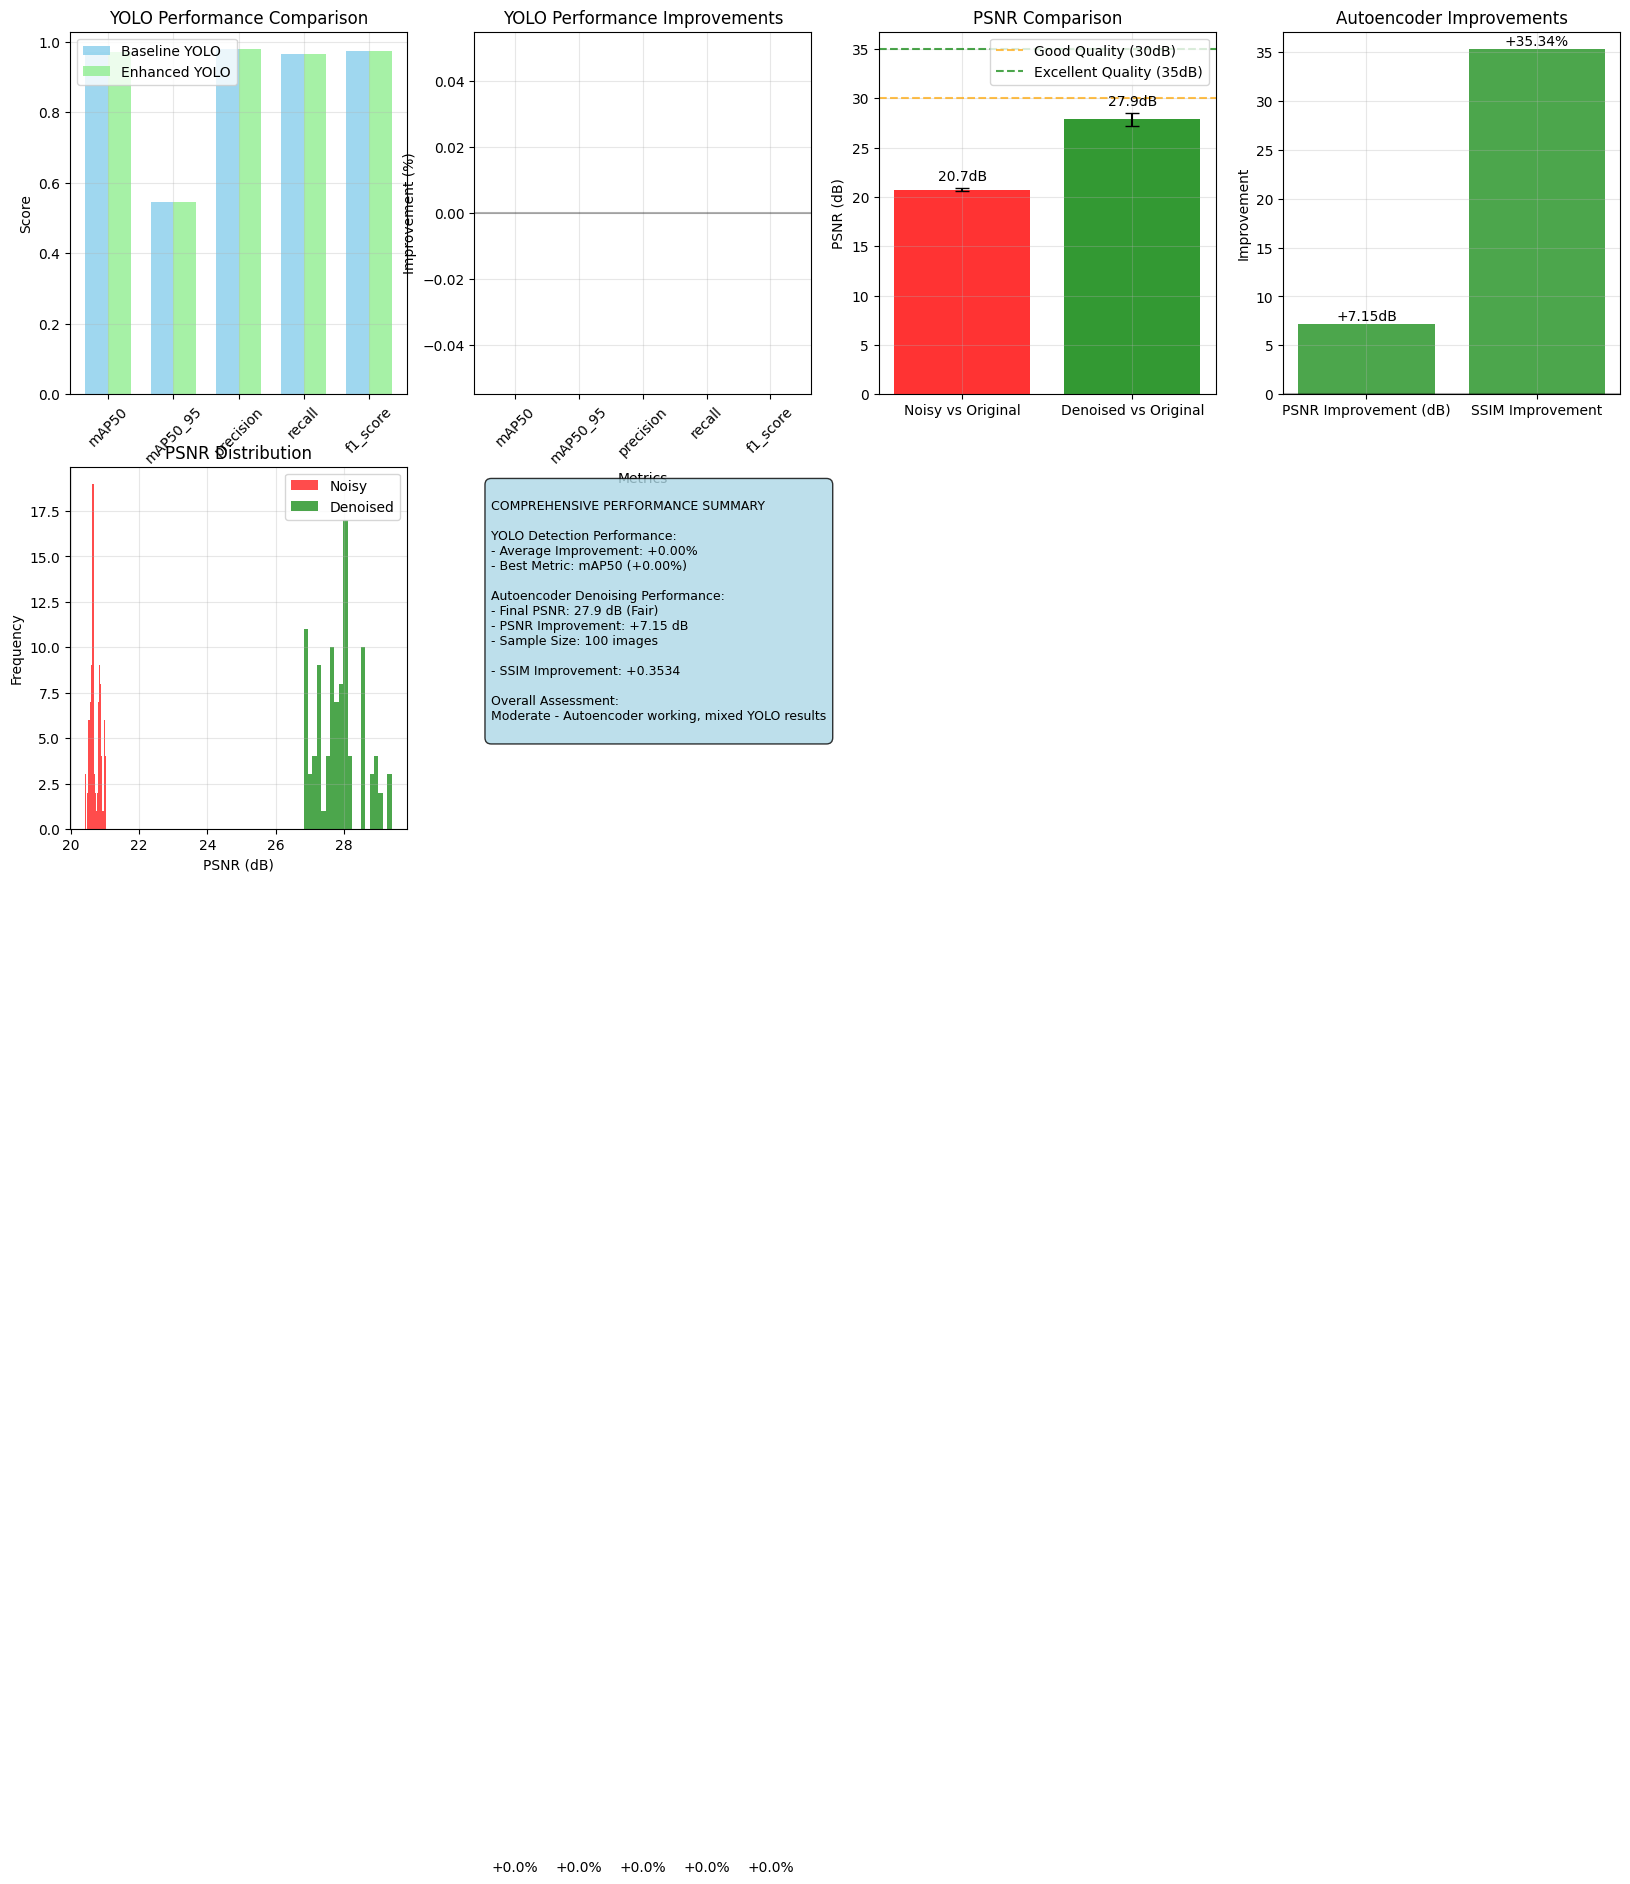

Comprehensive visualization with PSNR saved to: /content/drive/MyDrive/pcb_defect_detection/results/comprehensive_performance_with_psnr.png
Comprehensive results saved to: /content/drive/MyDrive/pcb_defect_detection/results/final_comprehensive_results.json

STEP 7: Sample Inference Demonstration
Running inference on 10 images...
   Processing 0/10 images...

image 1/1 /content/temp_datasets/test/images/rotation_270_light_05_missing_hole_05_2_600_jpg.rf.56d6c7bb0eb7d4701e8af04cd5ca0a81.jpg: 640x640 5 missing_holes, 8.7ms
Speed: 2.1ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict11

image 1/1 /content/temp_datasets/test/images/l_light_04_short_10_4_600_jpg.rf.cd925e761f26e975b5420ab704280f82.jpg: 640x640 1 short, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict11

image 1/1 /content/temp_datasets/test/images/

In [ ]:
# Run all the pipeline code from previous cells (Setup 1-9)

# Run the complete pipeline
results = run_complete_pcb_detection_pipeline(
    dataset_zip_path='/content/drive/MyDrive/pcb_defect_detection/datasets/PCB Defects DATASET.v2i.yolov11.zip',
    force_retrain_all=False  # Set to True to retrain from scratch
)


# Step 5: Testing and Evaluation

In [ ]:
performance_results = results['comprehensive_results']

print("Performance Summary:")
# print(f"YOLO Average Improvement: {performance_results}")
print(f"YOLO Average Improvement: {performance_results['yolo_performance']['average_improvement']:+.10f}%")
if performance_results['psnr_analysis']:
    psnr_improvement = performance_results['psnr_analysis']['improvements']['psnr_improvement']
    print(f"PSNR Improvement: {psnr_improvement:+.2f} dB")


Performance Summary:
YOLO Average Improvement: +0.0000000000%
PSNR Improvement: +7.15 dB


In [ ]:
performance_results['psnr_analysis']

{'sample_size': 100,
 'noisy_vs_original': {'average_psnr': np.float64(20.715019092559814),
  'std_psnr': np.float64(0.1526093616197752),
  'average_ssim': np.float64(0.39689424842596055),
  'std_ssim': np.float64(0.0428471212152675)},
 'denoised_vs_original': {'average_psnr': np.float64(27.865753726959227),
  'std_psnr': np.float64(0.6482586577272598),
  'average_ssim': np.float64(0.7503334194421768),
  'std_ssim': np.float64(0.02823716294902633)},
 'improvements': {'psnr_improvement': np.float64(7.150734634399413),
  'ssim_improvement': np.float64(0.35343917101621625),
  'quality_assessment': 'Fair'},
 'individual_psnr_values': {'noisy': [20.583520889282227,
   20.623891830444336,
   20.578222274780273,
   20.634017944335938,
   20.644969940185547,
   20.514108657836914,
   20.539798736572266,
   20.42108154296875,
   20.50303077697754,
   20.86052703857422,
   20.42904281616211,
   20.506025314331055,
   20.876800537109375,
   20.589744567871094,
   20.85965919494629,
   20.64724731

In [ ]:
# Quick check - What's in your performance_results?
print("Available keys in performance_results:")
for key in performance_results.keys():
    print(f"  - {key}")
    if isinstance(performance_results[key], dict):
        for subkey in performance_results[key].keys():
            print(f"    - {subkey}")


Available keys in performance_results:
  - evaluation_metadata
    - timestamp
    - baseline_model
    - enhanced_model
    - autoencoder_architecture
  - yolo_performance
    - baseline
    - enhanced
    - improvements
    - average_improvement
  - psnr_analysis
    - sample_size
    - noisy_vs_original
    - denoised_vs_original
    - improvements
    - individual_psnr_values
  - combined_assessment
    - yolo_avg_improvement
    - psnr_improvement
    - overall_success


In [ ]:
# ===== AUTOENCODER PERFORMANCE =====
psnr_data = performance_results['psnr_analysis']
avg_psnr_improvement = psnr_data['improvements']['psnr_improvement']
std_psnr_improvement = psnr_data['denoised_vs_original']['std_psnr']
avg_ssim = psnr_data['denoised_vs_original']['average_ssim']
std_ssim = psnr_data['denoised_vs_original']['std_ssim']

print(f'Average PSNR improvement: {avg_psnr_improvement:.1f} ± {std_psnr_improvement:.1f} dB')
print(f'SSIM score: {avg_ssim:.3f} ± {std_ssim:.3f}')

# ===== YOLO DETECTION RESULTS =====
yolo_data = performance_results['yolo_performance']
baseline_metrics = yolo_data['baseline']
enhanced_metrics = yolo_data['enhanced']

# Extract key metrics
baseline_map50 = baseline_metrics['mAP50']
baseline_map50_95 = baseline_metrics['mAP50_95']
baseline_f1 = baseline_metrics['f1_score']

enhanced_map50 = enhanced_metrics['mAP50']
enhanced_map50_95 = enhanced_metrics['mAP50_95']
enhanced_f1 = enhanced_metrics['f1_score']

# Calculate improvements
map50_improvement = enhanced_map50 - baseline_map50
map50_95_improvement = enhanced_map50_95 - baseline_map50_95
f1_improvement = enhanced_f1 - baseline_f1

# LaTeX Table Format
print('LaTeX Table Values:')
print(f'Baseline YOLOv11 & {baseline_map50:.3f} & {baseline_map50_95:.3f} & {baseline_f1:.3f} \\\\')
print(f'Enhanced YOLOv11 & {enhanced_map50:.3f} & {enhanced_map50_95:.3f} & {enhanced_f1:.3f} \\\\')
print(f'Improvement & {map50_improvement:+.3f} & {map50_95_improvement:+.3f} & {f1_improvement:+.3f} \\\\')

# ===== PER-CLASS DETECTION PERFORMANCE =====
if 'per_class_precision' in baseline_metrics:
    class_names = ['Missing hole', 'Mouse bite', 'Open circuit', 'Short circuit', 'Spur', 'Spurious copper']
    baseline_precisions = baseline_metrics['per_class_precision']
    enhanced_precisions = enhanced_metrics['per_class_precision']

    print('Per-class detection performance:')
    for i, class_name in enumerate(class_names):
        baseline_prec = baseline_precisions[i] * 100
        enhanced_prec = enhanced_precisions[i] * 100
        print(f'{class_name}: {baseline_prec:.1f}% → {enhanced_prec:.1f}%')
else:
    print('Per-class precision data not available')
    print('Available baseline metrics keys:', list(baseline_metrics.keys()))


Average PSNR improvement: 7.2 ± 0.6 dB
SSIM score: 0.750 ± 0.028
LaTeX Table Values:
Baseline YOLOv11 & 0.972 & 0.546 & 0.973 \\
Enhanced YOLOv11 & 0.972 & 0.546 & 0.973 \\
Improvement & +0.000 & +0.000 & +0.000 \\
Per-class precision data not available
Available baseline metrics keys: ['mAP50', 'mAP50_95', 'precision', 'recall', 'f1_score', 'inference_time', 'preprocessing_time', 'postprocessing_time']


In [ ]:
performance_results['yolo_performance']['enhanced']

{'mAP50': 0.9715264716807798,
 'mAP50_95': 0.5458930691336323,
 'precision': 0.97949341591666,
 'recall': 0.9661377092066495,
 'f1_score': 0.9727697227055225,
 'inference_time': 0,
 'preprocessing_time': 0,
 'postprocessing_time': 0}

In [ ]:
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-latex-extra

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-jav

In [ ]:
!jupyter nbconvert --to pdf "/content/Computer_Vision_Final_Project.ipynb"

[NbConvertApp] WARNING | pattern '/content/Computer_Vision_Final_Project.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.ans